<a href="https://colab.research.google.com/github/geekpradd/Reinforcement-Learning-Stock-Trader/blob/master/New_Stock_Updated1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [155]:
%matplotlib inline
import gym
from gym import spaces
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import random
from tensorflow.keras.layers import Dense, Concatenate, Lambda, Activation
from tensorflow.keras import Input
from tensorflow import convert_to_tensor as convert
import pickle
# COLAB = False
# if not COLAB:
#     import os
#     os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
path_base = ''
import os

In [193]:
class StockEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, df, params, train = True):
        super(StockEnv,self).__init__()
        
        self.num_stocks = params['num_stocks']
        self.min_brokerage = params['min_brokerage']
        self.brokerage_rate = params['brokerage_rate']
        self.balance_normal = params['balance_normal']
        self.shares_normal = params['shares_normal']
        self.volume_normal = params['volume_normal']
        self.dfs = df
        self.state_dimensions = self.num_stocks*5+1
        self.train = train

        assert len(df) == self.num_stocks, "Size of database not equal to number of stocks"

        self.max_steps = min([len(d.loc[:,'Open']) for d in self.dfs])
        self.action_space = spaces.Box(low = -1, high = 1, shape =  (1, self.num_stocks*2), dtype = np.float32)
        self.observation_space = spaces.Box(low = 0, high = 1, shape = (1, self.state_dimensions), dtype = np.float32)

    def reset(self, intial_balance = 10000, shares_held = None):

        if self.train:
            self.current_step = np.random.randint(0, self.max_steps)
        else:
            self.current_step = 0
        print('current_step',self.current_step)
        self.balance = intial_balance
        self.shares_held = shares_held
        if self.shares_held is None:
            self.shares_held = np.zeros((1, self.num_stocks))
        self.current_price = self.get_price()
        self.highest_price = 0
        self.net_worth = self.balance + np.sum(self.shares_held*self.current_price)
        self.initial_worth = self.net_worth
        self.max_net_worth = self.net_worth
        self.set_high()
        self.done = False
        self.frame = np.zeros((1, self.state_dimensions))
        self.info = {
            'current_step' : self.current_step,
            'current_price': self.current_price,
            'highest_price': self.highest_price,
            'net_worth' : self.net_worth,
            'max_net_worth': self.max_net_worth,
            'shares_held' : self.shares_held,
            'shares_normal' : self.shares_normal,
            'balance_normal' : self.balance_normal,
            'balance' : self.balance,
        }
        return self.observe()
        
    def get_price(self):
#         for df in self.dfs:
#             #print(self.current_step, [df.loc[self.current_step,"Low"], df.loc[self.current_step,"High"]])
        return np.array([np.random.uniform(df.loc[self.current_step,"Low"], df.loc[self.current_step,"High"]) for df in self.dfs]).reshape((1, self.num_stocks))
      
    def set_high(self):
        high = np.array([df.loc[self.current_step, 'High'] for df in self.dfs]).reshape((1, self.num_stocks))
        self.highest_price = np.maximum(self.highest_price, high)
        for i in range(self.highest_price.shape[1]):
            if not np.isfinite(self.highest_price[0][i]):
                self.highest_price[0][i]=1

    def observe(self):
        for i in range(self.num_stocks):
            self.frame[0, 4*i:4*i+4] = np.array([self.dfs[i].loc[self.current_step,'Open'],self.dfs[i].loc[self.current_step,'High'],self.dfs[i].loc[self.current_step,'Low'],self.dfs[i].loc[self.current_step,'Close']])/self.highest_price[0, i]
        self.frame[0, self.num_stocks*4:self.num_stocks*5] = self.shares_held/self.shares_normal
        self.frame[0, 5*self.num_stocks] = self.balance/self.balance_normal
        self.info = {
            'current_step' : self.current_step,
            'current_price': self.current_price,
            'highest_price': self.highest_price,
            'net_worth' : self.net_worth,
            'max_net_worth': self.max_net_worth,
            'shares_held' : self.shares_held,
            'shares_normal' : self.shares_normal,
            'balance_normal' : self.balance_normal,
            'balance' : self.balance
        }
        return self.frame, self.info
    
    def update_worth(self, reward):
        self.net_worth += reward
        self.max_net_worth = max(self.max_net_worth, self.net_worth)

    def update_balance(self, action):
        self.balance += np.sum(action[:, :self.num_stocks]*self.current_price)
        self.balance -= np.sum(action[:, self.num_stocks:]*self.current_price)

    def update_shares(self, action):
        self.shares_held -= action[:, :self.num_stocks]
        self.shares_held +=  action[:, self.num_stocks:]

    def take_action(self, action):
        self.current_price = self.get_price()
        action[:, :self.num_stocks] = np.floor(action[:, :self.num_stocks] *self.shares_held)
        if not np.isfinite(self.current_price).all():
            print('gadbad in current price')
            self.current_price=np.ones(self.current_price.shape)
        action[:, self.num_stocks:] = np.floor(action[:, self.num_stocks:] * self.balance / self.current_price)
        self.set_high()
        self.update_balance(action)
        self.update_shares(action)
        reward = self.balance + np.sum(self.shares_held * self.current_price) - self.net_worth
        self.update_worth(reward)
        return reward
            
    def step(self, action):
        self.current_step += 1
        if self.current_step >= self.max_steps or self.done:
            self.done = True
            return np.zeros((1, self.state_dimensions)), 0, self.done, self.info
        if np.sum(action[:, self.num_stocks:]) > 1:
            print('gadbad')
        reward = self.take_action(action)
        self.done = self.net_worth <= self.initial_worth*0.05
        if self.done:
            print('snap')
        obs, info = self.observe()
        return obs, reward, self.done, info
    
    def render(self, mode='human', close = False):
        profit = self.net_worth - self.initial_worth
        print('Step: {}'.format(self.current_step))
        print('Net Worth: {}'.format(self.net_worth))
        print('Profit: {}'.format(profit))
        
def create_stock_env(locations, train=True):
    dfs = [pd.read_csv(location).sort_values('Date') for location in locations]
    params = {
        'num_stocks' : len(locations),
        'min_brokerage' : 30.0,
        'brokerage_rate' : 0.001,
        'balance_normal' : 1000000,
        'shares_normal' : 10000,
        'volume_normal' : 2147483647,
    }
    return StockEnv(dfs, params, train)

In [194]:
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.size = buffer_size
        self.buffer = deque()
        
    def add(self, data_tuple):
        self.buffer.append(data_tuple)
        if len(self.buffer) > self.size:
            self.buffer.popleft()
            
    def sample(self, sample_size):
        size = min(len(self.buffer), sample_size)
        return random.sample(self.buffer, size), size
        
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma=0.3, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

In [ ]:
class Actor:
    def __init__(self, params):
        self.output_range = params["output_range"]
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.cap = params['cap']
        self.actor = self.build_model()
        
    def build_model(self):
        inputs = Input(shape=(self.state_dimensions, ))
        x = Dense(512, activation = 'relu')(inputs)
        x = Dense(256, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        sell = Dense(self.action_dimensions, activation = 'sigmoid')(x)
        buy = Dense(self.action_dimensions, activation = 'sigmoid')(x)
        final_buy = Activation(tf.keras.activations.softmax)(buy)*tf.math.minimum(self.cap, tf.reduce_sum(buy, axis = -1, keepdims = True))
        model = keras.Model(inputs = inputs, outputs = tf.concat([sell, final_buy], axis = -1))
        # model.summary()
        return model
    
    def get_action(self, state):
        return self.actor(convert(state))

    def save(self):
        self.actor.save(path_base + 'actor.h5')
    
    def load(self):
        self.actor = keras.models.load_model(path_base + 'actor.h5')
        print('Successfully Loaded')

class Critic:
    def __init__(self, params):
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.optimizer = params["critic_optimizer"]
        self.tau = params['tau']
        self.critic_online = self.build_model()
        self.critic_target = self.build_model()
        self.critic_online.set_weights(self.critic_target.get_weights())

    def build_model(self):
        input_a = Input(shape = (self.state_dimensions, ))
        input_b = Input(shape = (2*self.action_dimensions, ))
        input = Concatenate(axis = -1)([input_a, input_b])
        x = Dense(256, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        output = Dense(1)(x)
        model = keras.Model(inputs=[input_a, input_b], outputs = output)
        model.compile(loss='mse', optimizer = keras.optimizers.Adam(learning_rate = 0.001))
        # model.summary()
        return model

    def save(self):
        self.critic_online.save(path_base + 'critic_online.h5')
        self.critic_target.save(path_base + 'critic_target.h5')

    def load(self):
        self.critic_online = keras.models.load_model(path_base + 'critic_online.h5')
        self.critic_target = keras.models.load_model(path_base + 'critic_target.h5')

    def get_qvalues(self, state_array, action_array, online=True):
        if online:
            return self.critic_online([convert(state_array), convert(action_array)])
        else:
            return self.critic_target([convert(state_array), convert(action_array)])

    def call(self, state_tensor, action_tensor):
        return self.critic_online([state_tensor, action_tensor])
    
    def merge(self):
        self.critic_target.set_weights(self.tau*np.array(self.critic_online.get_weights())
                                                                    + (1-self.tau)*np.array(self.critic_target.get_weights()))

In [ ]:
class Agent:
    def __init__(self, params, train = True, resume = True):
        self.back_state = 100
        self.train = train
        params["state_dimensions"]=params['state']*self.back_state
        self.actor = Actor(params)
        self.critic = Critic(params)
        self.buffer = ReplayMemory(params["buffer_size"])
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.discount = params["discount"]
        self.action_range = params["output_range"]
        self.save_frequency = params["save_frequency"]
        self.batch_size = params["batch_size"]
        self.optimizer = params["actor_optimizer"]
        self.cap = params['cap']
        self.num_steps = 0
        self.state = np.zeros((self.back_state,self.state_dimensions//self.back_state))
        self.have_state = 1
        self.noise_func =  OrnsteinUhlenbeckActionNoise(mu=np.zeros(2*params["action_dimensions"]))
        if resume:
            self.load()
    def agent_start(self):
        self.state = np.zeros((self.back_state,self.state_dimensions//self.back_state))
        self.have_state=1
#         if self.train:
#             action = self.clip_action(action + self.noise_func())
#         else:
#             action = self.clip_action(action)

    def clip_action(self, action):
        action = np.clip(action, 0, self.action_range)
        sum = np.sum(action, axis = -1, keepdims = True)
        if sum==0:
            return action
        action = action*np.minimum(sum, self.cap)/sum
        return action

    def agent_step(self, reward, observation):
#         print(self.state)
#         print(self.state.shape)
        if self.have_state < self.back_state:
            action = np.zeros((1,self.action_dimensions*2))
            self.state[self.have_state-1] = observation
            self.have_state += 1
            self.prev_action = action
            self.prev_state = np.reshape(self.state, [1,self.state_dimensions])
            return self.prev_action
        if self.have_state == self.back_state:
            self.state[-1] = observation
            #print(self.state)
            action = self.actor.get_action(np.reshape(self.state, [1,self.state_dimensions]))
            if self.train:
                action = self.clip_action(action + self.noise_func())
            else:
                action = self.clip_action(action)
            self.prev_state = np.reshape(self.state, [1,self.state_dimensions])
            self.prev_action = action
            self.have_state+=1
            return self.prev_action
        
#         print(self.state.shape)
        self.state = self.state[1:,:]
        self.state = np.append(self.state,observation,axis=0)
#         print(self.state)
#         print(self.state.shape)
        state = np.reshape(self.state, [1,self.state_dimensions])
        if self.train:
            replay = (self.prev_state, self.prev_action, reward, state)
            self.buffer.append(replay)
            
        action = self.actor.get_action(state)
        if self.train:
            action = self.clip_action(action + self.noise_func())
            self.run()
        else:
            action = self.clip_action(action)
        self.prev_action = action
        self.prev_state = state
        return self.prev_action 
    
    def save(self):
        print('saving')
        self.actor.save()
        self.critic.save()
        data = (self.buffer, self.num_steps, self.noise_func)
        with open (path_base + 'auxiliary.pkl', 'wb') as f:
            pickle.dump(data, f)

    def load(self):
        print('loading')
        self.actor.load()
        self.critic.load()
        with open (path_base + 'auxiliary.pkl', 'rb') as f:
            data = pickle.load(f)
        self.buffer, self.num_steps, self.noise_func = data
    
    def run(self):
        self.num_steps += 1
        size = min(self.batch_size, self.buffer.size)
        batch = self.buffer.sample(size)

        prev_states = np.array([x[0] for x in batch]).reshape((-1, self.state_dimensions))
        prev_actions = np.array([x[1] for x in batch]).reshape((-1, 2*self.action_dimensions))
        rewards = np.array([x[2] for x in batch]).reshape((-1, 1))
        states = np.array([x[3] for x in batch]).reshape((-1, self.state_dimensions))
        actions = self.actor.get_action(states)
        q_values = self.critic.get_qvalues(states, actions, False)
        q_values += self.discount*rewards
        self.critic.critic_online.fit([states, actions], q_values, epochs = 1, verbose=0)

        prev_state_tensor = convert(prev_states)
        prev_action_tensor = convert(prev_actions)
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(prev_action_tensor)
            value = self.critic.call(prev_state_tensor, prev_action_tensor)
            action = self.actor.actor(prev_state_tensor)
        gradient = -tape.gradient(value, prev_action_tensor)
        gradient = tf.cast(gradient, tf.float32)
        gradient_actor = tape.gradient(action, self.actor.actor.trainable_weights, gradient)
        gradient_actor = list(np.array(gradient_actor)/size)

        self.optimizer.apply_gradients(zip(gradient_actor, self.actor.actor.trainable_weights))
        self.critic.merge()

        if self.num_steps % self.save_frequency == 0:
            self.save()

In [261]:
AGENT_PARAMS = {
	"output_range": 1,
	"state": 6,
	"action_dimensions": 1,
	"critic_optimizer": tf.keras.optimizers.Adam(learning_rate = 0.0001),
	"actor_optimizer": tf.keras.optimizers.Adam(learning_rate = 0.00005),
	"batch_size": 64,
	"buffer_size":100000,
	"discount": 0.99,
	"tau": 0.001,
	"save_frequency": 5000,
	'cap' : 0.9,
}

In [272]:
epochs_per_iter = 100

def train(agent, env, epochs, profits, balances, shares, actions):

    steps_per_epoch = 5000
    
    for epoch in range(epochs, epochs + epochs_per_iter+1):

        cumm_profit = 0
        observation, info = env.reset()
        shares[epoch, 0, :] = info['shares_held']
        balances[epoch, 0] = info['balance']
        agent.agent_start()
        action = agent.agent_step(0,observation)
        actions[epoch, 0, :] = action

        for i in tqdm(range(steps_per_epoch)):

            observation, reward, done, info = env.step(action)
            shares[epoch, i+1, :] = info['shares_held']
            balances[epoch, i+1] = info['balance']
            cumm_profit += reward
            profits[epoch, i] = cumm_profit
            if done:
                break
            action = agent.agent_step(reward, observation)
#             if i%400==0:
#                 print(i,action)
            if not np.isfinite(action).all():
                for att in vars(agent):
                    print (att, getattr(agent,att))
                print('--------------------------------------------------------------------------------------------------')
                for att in vars(agent.actor):
                    print (att, getattr(agent.actor,att))
                print('--------------------------------------------------------------------------------------------------')
                # print(--------------------------------------------------------------------------------------------------------)
                for att in vars(agent.critic):
                    print (att, getattr(agent.critic,att)) 
                print('--------------------------------------------------------------------------------------------------')
                #print(--------------------------------------------------------------------------------------------------------)
                for att in vars(env):
                    print (att, getattr(env,att))
                print('--------------------------------------------------------------------------------------------------')
                #     print(--------------------------------------------------------------------------------------------------------)
                break
                for name, value in globals().items():
                     print(name, value)
            actions[epoch, i+1, :] = action
        print(action)
        print('Completed epoch' + str(epoch))
        print(profits[epoch,i])
        if epoch % 10 == 0:
            data = epoch, profits, shares, balances, actions
            with open(path_base + 'graph.pkl', 'wb') as f:
                pickle.dump(data, f)

In [273]:
stocks = ['IBM.csv','GOOG.csv', 'AAPL.csv', 'MSFT.csv','AMZN.csv','DXC.csv','INFY.csv','M.csv','PCG.csv', 'PNB.csv', 'RELIN.csv','BPCL.csv']
files = ['INFY.csv']
env = create_stock_env(files,train= False)
tf.keras.backend.set_floatx('float32')
agent = Agent(AGENT_PARAMS, train = True,resume = True)

In [275]:
steps_per_epoch = 5000
print(agent.num_steps)
stocks = ['IBM.csv','GOOG.csv', 'AAPL.csv', 'MSFT.csv','AMZN.csv','DXC.csv','INFY.csv','M.csv','PCG.csv', 'PNB.csv', 'RELIN.csv','BPCL.csv']
#while epochs<600:
data = [0,np.zeros((50*epochs_per_iter,steps_per_epoch)),np.zeros((50*epochs_per_iter,steps_per_epoch+1,1)),np.zeros((50*epochs_per_iter,1+steps_per_epoch)),np.zeros((50*epochs_per_iter,1+steps_per_epoch,2))]    
for f in stocks:
    env = create_stock_env([f],train= True)
    agent = Agent(AGENT_PARAMS, train = True,resume = True)
    epochs, profits, shares, balances, actions = data
    train(agent, env, epochs, profits, balances, shares, actions)
    epochs+=epochs_per_iter
    with open(path_base + 'graph.pkl', 'rb') as f:
        data = pickle.load(f)
    for i in range(50):
        os.system("printf '\a'") # or '\7'

  0%|          | 3/5000 [00:00<03:37, 23.01it/s]

2216
current_step 3141
0 [[0.06503575 0.35673577]]


  8%|▊         | 405/5000 [00:16<03:08, 24.40it/s]

400 [[0.14348245 0.        ]]


 16%|█▌        | 804/5000 [00:33<02:52, 24.29it/s]

800 [[0. 0.]]


 24%|██▍       | 1203/5000 [00:50<02:41, 23.52it/s]

1200 [[0. 0.]]


 32%|███▏      | 1605/5000 [01:07<02:23, 23.58it/s]

1600 [[0.        0.3573808]]


 40%|████      | 2004/5000 [01:24<02:04, 24.13it/s]

2000 [[0. 0.]]


 48%|████▊     | 2403/5000 [01:40<01:50, 23.59it/s]

2400 [[0.22504841 0.17181735]]


 56%|█████▌    | 2784/5000 [01:57<02:03, 17.91it/s]

saving


 56%|█████▌    | 2805/5000 [01:57<01:35, 23.10it/s]

2800 [[0.         0.16165528]]


 64%|██████▍   | 3204/5000 [02:14<01:16, 23.39it/s]

3200 [[0.         0.08781906]]


 72%|███████▏  | 3603/5000 [02:31<00:58, 23.80it/s]

3600 [[0. 0.]]


 80%|████████  | 4005/5000 [02:48<00:42, 23.36it/s]

4000 [[0. 0.]]


 88%|████████▊ | 4404/5000 [03:06<00:25, 23.52it/s]

4400 [[0. 0.]]


 96%|█████████▌| 4803/5000 [03:23<00:08, 23.45it/s]

4800 [[0. 0.]]


100%|██████████| 5000/5000 [03:31<00:00, 23.62it/s]


[[0. 0.]]
Completed epoch0
9179.479275213875


  0%|          | 3/5000 [00:00<03:33, 23.39it/s]

current_step 2694
0 [[0. 0.]]


  8%|▊         | 405/5000 [00:17<03:21, 22.78it/s]

400 [[0.54106313 0.3589369 ]]


 16%|█▌        | 804/5000 [00:34<03:00, 23.29it/s]

800 [[0.64491445 0.25508553]]


 24%|██▍       | 1203/5000 [00:51<02:42, 23.34it/s]

1200 [[0.7250891  0.17491095]]


 32%|███▏      | 1605/5000 [01:08<02:26, 23.15it/s]

1600 [[0.5733067  0.32669336]]


 40%|████      | 2004/5000 [01:25<02:06, 23.70it/s]

2000 [[0.9 0. ]]


 48%|████▊     | 2403/5000 [01:43<01:51, 23.30it/s]

2400 [[0.5129314  0.38706857]]


 56%|█████▌    | 2784/5000 [01:59<02:02, 18.15it/s]

saving


 56%|█████▌    | 2805/5000 [02:00<01:35, 22.96it/s]

2800 [[0.4408394  0.45916057]]


 64%|██████▍   | 3204/5000 [02:17<01:16, 23.56it/s]

3200 [[0.6542283  0.24577166]]


 72%|███████▏  | 3603/5000 [02:34<00:59, 23.42it/s]

3600 [[0.54867923 0.3513208 ]]


 80%|████████  | 4005/5000 [02:51<00:42, 23.63it/s]

4000 [[0.31690392 0.5830961 ]]


 88%|████████▊ | 4404/5000 [03:08<00:25, 23.37it/s]

4400 [[0.39737648 0.50262344]]


 96%|█████████▌| 4803/5000 [03:25<00:08, 23.72it/s]

4800 [[0.24416737 0.6558326 ]]


  0%|          | 3/5000 [00:00<03:31, 23.60it/s]

[[0.4321893  0.46781072]]
Completed epoch1
1110.2402972005038
current_step 1443
0 [[0.5583179 0.       ]]


  8%|▊         | 405/5000 [00:17<03:13, 23.77it/s]

400 [[0.40619636 0.36054733]]


 16%|█▌        | 804/5000 [00:34<03:00, 23.28it/s]

800 [[0.07681763 0.00088954]]


 24%|██▍       | 1203/5000 [00:51<02:42, 23.40it/s]

1200 [[0.9 0. ]]


 32%|███▏      | 1605/5000 [01:09<02:24, 23.53it/s]

1600 [[0.5314148  0.36858517]]


 40%|████      | 2004/5000 [01:26<02:08, 23.26it/s]

2000 [[0.85043615 0.04956377]]


 48%|████▊     | 2403/5000 [01:43<01:51, 23.24it/s]

2400 [[0.7914827  0.10851727]]


 56%|█████▌    | 2784/5000 [01:59<02:15, 16.32it/s]

saving


 56%|█████▌    | 2805/5000 [02:00<01:37, 22.41it/s]

2800 [[0.5401829 0.3598171]]


 64%|██████▍   | 3204/5000 [02:17<01:16, 23.50it/s]

3200 [[0.41803694 0.48196304]]


 72%|███████▏  | 3603/5000 [02:34<00:59, 23.56it/s]

3600 [[0.45 0.45]]


 80%|████████  | 4005/5000 [02:51<00:42, 23.29it/s]

4000 [[0.43441236 0.46558765]]


 88%|████████▊ | 4404/5000 [03:08<00:25, 23.59it/s]

4400 [[0.9 0. ]]


 96%|█████████▌| 4803/5000 [03:25<00:08, 23.73it/s]

4800 [[0.17546922 0.72453076]]


  0%|          | 3/5000 [00:00<03:34, 23.30it/s]

[[0.5359224 0.3640775]]
Completed epoch2
7801.388819513566
current_step 12770
0 [[0.5685437  0.33145627]]


  8%|▊         | 405/5000 [00:17<03:17, 23.26it/s]

400 [[0.9 0. ]]


 16%|█▌        | 804/5000 [00:34<02:57, 23.64it/s]

800 [[0.3498764 0.479117 ]]


 24%|██▍       | 1203/5000 [00:51<02:41, 23.49it/s]

1200 [[0.33379892 0.56620103]]


 32%|███▏      | 1605/5000 [01:08<02:24, 23.42it/s]

1600 [[0.45 0.45]]


  0%|          | 3/5000 [00:00<03:39, 22.78it/s]

[[0.45 0.45]]
Completed epoch3
-1313.8635483630824
current_step 1264
0 [[0.4854444  0.41455555]]


  8%|▊         | 405/5000 [00:17<03:14, 23.63it/s]

400 [[0.45721614 0.44278383]]


 16%|█▌        | 804/5000 [00:34<02:59, 23.31it/s]

800 [[0.31503072 0.5849693 ]]


 17%|█▋        | 834/5000 [00:36<02:56, 23.57it/s]

saving


 24%|██▍       | 1203/5000 [00:51<02:41, 23.47it/s]

1200 [[0.27044934 0.6295506 ]]


 32%|███▏      | 1605/5000 [01:09<02:23, 23.59it/s]

1600 [[0.3437337 0.5562663]]


 40%|████      | 2004/5000 [01:26<02:07, 23.57it/s]

2000 [[0.45 0.45]]


 48%|████▊     | 2403/5000 [01:43<01:50, 23.53it/s]

2400 [[0.5925382 0.3074618]]


 56%|█████▌    | 2805/5000 [02:00<01:31, 23.88it/s]

2800 [[0.62313175 0.27686825]]


 64%|██████▍   | 3204/5000 [02:17<01:15, 23.71it/s]

3200 [[0.49077347 0.40922648]]


 72%|███████▏  | 3603/5000 [02:34<00:58, 23.70it/s]

3600 [[0.53281313 0.36718684]]


 80%|████████  | 4005/5000 [02:51<00:41, 23.91it/s]

4000 [[0.         0.72494787]]


 88%|████████▊ | 4404/5000 [03:08<00:25, 23.53it/s]

4400 [[0.  0.9]]


 96%|█████████▌| 4803/5000 [03:25<00:08, 23.60it/s]

4800 [[0.18891275 0.7110872 ]]


  0%|          | 3/5000 [00:00<03:29, 23.88it/s]

[[0.45 0.45]]
Completed epoch4
19340.395520920712
current_step 12984
0 [[0.34288833 0.5571116 ]]


  8%|▊         | 405/5000 [00:17<03:16, 23.42it/s]

400 [[0.39571393 0.50428605]]


 16%|█▌        | 804/5000 [00:34<02:54, 24.04it/s]

800 [[0.3708941 0.5291059]]


 17%|█▋        | 834/5000 [00:35<02:55, 23.77it/s]

saving


 24%|██▍       | 1203/5000 [00:51<02:40, 23.59it/s]

1200 [[0.44321534 0.45678467]]


 32%|███▏      | 1605/5000 [01:08<02:24, 23.50it/s]

1600 [[0.0557039 0.8442961]]


  0%|          | 3/5000 [00:00<03:28, 23.97it/s]

[[0.33094305 0.5690569 ]]
Completed epoch5
-3143.486332359512
current_step 9611
0 [[0.  0.9]]


  8%|▊         | 405/5000 [00:17<03:14, 23.67it/s]

400 [[0.15313971 0.7468602 ]]


 16%|█▌        | 804/5000 [00:34<02:59, 23.42it/s]

800 [[0.342561  0.5574389]]


 24%|██▍       | 1203/5000 [00:51<02:41, 23.52it/s]

1200 [[0.4810474  0.41895252]]


 32%|███▏      | 1605/5000 [01:08<02:26, 23.21it/s]

1600 [[0.3855473  0.51445264]]


 40%|████      | 2004/5000 [01:25<02:07, 23.56it/s]

2000 [[0.20164776 0.69835216]]


 48%|████▊     | 2403/5000 [01:43<01:49, 23.75it/s]

2400 [[0.         0.85771734]]


 56%|█████▌    | 2805/5000 [02:00<01:34, 23.27it/s]

2800 [[0.2572326  0.64276737]]


 64%|██████▍   | 3204/5000 [02:17<01:16, 23.62it/s]

3200 [[0.36850384 0.53149617]]


 72%|███████▏  | 3603/5000 [02:34<00:58, 23.77it/s]

3600 [[0.4328572  0.46714282]]


 80%|████████  | 4005/5000 [02:51<00:42, 23.24it/s]

4000 [[0.79747605 0.1025239 ]]


 82%|████████▏ | 4101/5000 [02:55<00:38, 23.51it/s]

saving


 88%|████████▊ | 4404/5000 [03:08<00:25, 23.29it/s]

4400 [[0.9 0. ]]


 96%|█████████▌| 4803/5000 [03:25<00:08, 23.43it/s]

4800 [[0.45 0.45]]


  0%|          | 3/5000 [00:00<03:34, 23.31it/s]

[[0.45 0.45]]
Completed epoch6
42.27000825093637
current_step 3545
0 [[0.2499339 0.650066 ]]


  8%|▊         | 405/5000 [00:17<03:15, 23.48it/s]

400 [[0.2895038  0.61049616]]


 16%|█▌        | 804/5000 [00:34<02:59, 23.37it/s]

800 [[0.28518367 0.6148163 ]]


 24%|██▍       | 1203/5000 [00:51<02:40, 23.61it/s]

1200 [[0.33111045 0.5688895 ]]


 32%|███▏      | 1605/5000 [01:08<02:27, 23.07it/s]

1600 [[0.32186976 0.57813025]]


 40%|████      | 2004/5000 [01:25<02:04, 24.15it/s]

2000 [[0.15487294 0.7451271 ]]


 48%|████▊     | 2403/5000 [01:42<01:48, 23.90it/s]

2400 [[0.37539616 0.52460384]]


 56%|█████▌    | 2805/5000 [01:59<01:32, 23.85it/s]

2800 [[0.5355663 0.2560156]]


 64%|██████▍   | 3204/5000 [02:16<01:15, 23.79it/s]

3200 [[0.49282983 0.40717015]]


 72%|███████▏  | 3603/5000 [02:33<01:00, 23.22it/s]

3600 [[0.23255429 0.6674457 ]]


 80%|████████  | 4005/5000 [02:50<00:43, 23.09it/s]

4000 [[0.51398283 0.38601717]]


 82%|████████▏ | 4101/5000 [02:55<00:38, 23.17it/s]

saving


 88%|████████▊ | 4404/5000 [03:08<00:25, 23.49it/s]

4400 [[0.45 0.45]]


 96%|█████████▌| 4803/5000 [03:25<00:08, 23.44it/s]

4800 [[0.  0.9]]


  0%|          | 3/5000 [00:00<03:27, 24.06it/s]

[[0.  0.9]]
Completed epoch7
5652.586633555222
current_step 9877
0 [[0.  0.9]]


  8%|▊         | 405/5000 [00:17<03:14, 23.66it/s]

400 [[0.         0.24814928]]


 16%|█▌        | 804/5000 [00:34<02:59, 23.43it/s]

800 [[0.        0.6583961]]


 24%|██▍       | 1203/5000 [00:51<02:41, 23.52it/s]

1200 [[0.67188597 0.22811405]]


 32%|███▏      | 1605/5000 [01:08<02:24, 23.56it/s]

1600 [[0.07071327 0.8292867 ]]


 40%|████      | 2004/5000 [01:25<02:06, 23.71it/s]

2000 [[0.  0.9]]


 48%|████▊     | 2403/5000 [01:42<01:50, 23.54it/s]

2400 [[0.  0.9]]


 56%|█████▌    | 2805/5000 [01:59<01:32, 23.75it/s]

2800 [[0.36581627 0.5341837 ]]


 64%|██████▍   | 3204/5000 [02:16<01:16, 23.50it/s]

3200 [[0.2359886  0.66401136]]


 72%|███████▏  | 3603/5000 [02:33<00:59, 23.50it/s]

3600 [[0.  0.9]]


 80%|████████  | 4005/5000 [02:51<00:41, 23.79it/s]

4000 [[0.41575062 0.48424935]]


 82%|████████▏ | 4101/5000 [02:55<00:38, 23.59it/s]

saving


 88%|████████▊ | 4404/5000 [03:08<00:25, 23.18it/s]

4400 [[0.290482 0.609518]]


 96%|█████████▌| 4803/5000 [03:25<00:08, 23.70it/s]

4800 [[0.23149462 0.6685053 ]]


  0%|          | 3/5000 [00:00<03:35, 23.21it/s]

[[0.1517012  0.74829876]]
Completed epoch8
3871.4415711180136
current_step 11348
0 [[0.1873278 0.7126722]]


  8%|▊         | 405/5000 [00:17<03:11, 23.95it/s]

400 [[0.12897915 0.77102077]]


 16%|█▌        | 804/5000 [00:34<02:56, 23.72it/s]

800 [[0.03795322 0.8620468 ]]


 24%|██▍       | 1203/5000 [00:51<02:42, 23.40it/s]

1200 [[0.34423792 0.55576205]]


 32%|███▏      | 1605/5000 [01:08<02:24, 23.52it/s]

1600 [[0.09488437 0.8051156 ]]


 40%|████      | 2004/5000 [01:25<02:07, 23.42it/s]

2000 [[0.59745276 0.30254725]]


 48%|████▊     | 2403/5000 [01:42<01:51, 23.35it/s]

2400 [[0.         0.63567615]]


 56%|█████▌    | 2805/5000 [01:59<01:33, 23.40it/s]

2800 [[0.23765948 0.6623405 ]]


 64%|██████▍   | 3204/5000 [02:16<01:15, 23.73it/s]

3200 [[0.42820388 0.4717961 ]]


  0%|          | 3/5000 [00:00<03:30, 23.73it/s]

[[0.45 0.45]]
Completed epoch9
4162.800028153797
current_step 5578
0 [[0.45 0.45]]


  8%|▊         | 405/5000 [00:17<03:15, 23.55it/s]

400 [[0.45 0.45]]


 16%|█▌        | 804/5000 [00:34<02:57, 23.68it/s]

800 [[0.35363364 0.54636633]]


 18%|█▊        | 894/5000 [00:38<02:55, 23.37it/s]

saving


 24%|██▍       | 1203/5000 [00:51<02:40, 23.67it/s]

1200 [[0.45 0.45]]


 32%|███▏      | 1605/5000 [01:08<02:23, 23.63it/s]

1600 [[0.39299476 0.4619563 ]]


 40%|████      | 2004/5000 [01:25<02:07, 23.48it/s]

2000 [[0.30657074 0.46209016]]


 48%|████▊     | 2403/5000 [01:43<01:50, 23.44it/s]

2400 [[0.81604576 0.08395416]]


 56%|█████▌    | 2805/5000 [02:00<01:33, 23.43it/s]

2800 [[0.5475006  0.30140942]]


 64%|██████▍   | 3204/5000 [02:17<01:15, 23.86it/s]

3200 [[0.  0.9]]


 72%|███████▏  | 3603/5000 [02:34<00:59, 23.47it/s]

3600 [[0.  0.9]]


 80%|████████  | 4005/5000 [02:51<00:42, 23.48it/s]

4000 [[0.  0.9]]


 88%|████████▊ | 4404/5000 [03:08<00:25, 23.33it/s]

4400 [[0.  0.9]]


 96%|█████████▌| 4803/5000 [03:25<00:08, 23.54it/s]

4800 [[0.25191045 0.6480895 ]]


100%|██████████| 5000/5000 [03:33<00:00, 23.39it/s]


[[0.1441288 0.7558711]]
Completed epoch10
11134.499405042487


  0%|          | 3/5000 [00:00<03:27, 24.07it/s]

current_step 3949
0 [[0.10970519 0.7902948 ]]


  8%|▊         | 405/5000 [00:17<03:16, 23.41it/s]

400 [[0.54557455 0.3544254 ]]


 16%|█▌        | 804/5000 [00:34<02:58, 23.57it/s]

800 [[0.88575834 0.01424164]]


 18%|█▊        | 894/5000 [00:38<02:55, 23.40it/s]

saving


 24%|██▍       | 1203/5000 [00:51<02:41, 23.45it/s]

1200 [[0.40320784 0.49679214]]


 32%|███▏      | 1605/5000 [01:08<02:24, 23.57it/s]

1600 [[0.  0.9]]


 40%|████      | 2004/5000 [01:25<02:06, 23.63it/s]

2000 [[0.13197325 0.7680267 ]]


 48%|████▊     | 2403/5000 [01:42<01:49, 23.64it/s]

2400 [[0.3031787 0.4038834]]


 56%|█████▌    | 2805/5000 [02:00<01:33, 23.36it/s]

2800 [[0.         0.64942765]]


 64%|██████▍   | 3204/5000 [02:16<01:16, 23.42it/s]

3200 [[0.        0.4321168]]


 72%|███████▏  | 3603/5000 [02:33<00:59, 23.51it/s]

3600 [[0.         0.36377865]]


 80%|████████  | 4005/5000 [02:51<00:43, 22.62it/s]

4000 [[0.         0.24781442]]


 88%|████████▊ | 4404/5000 [03:08<00:25, 23.55it/s]

4400 [[0.3229356  0.36071545]]


 96%|█████████▌| 4803/5000 [03:25<00:08, 23.47it/s]

4800 [[0.34291378 0.5570862 ]]


  0%|          | 3/5000 [00:00<03:32, 23.57it/s]

[[0.04712177 0.7087419 ]]
Completed epoch11
6878.678108277905
current_step 12894
0 [[0.10089467 0.68579257]]


  8%|▊         | 405/5000 [00:17<03:15, 23.54it/s]

400 [[0.14212975 0.75787026]]


 16%|█▌        | 804/5000 [00:34<03:03, 22.88it/s]

800 [[0.2998172 0.6001828]]


 18%|█▊        | 894/5000 [00:37<02:53, 23.63it/s]

saving


 24%|██▍       | 1203/5000 [00:51<02:40, 23.59it/s]

1200 [[0.65074134 0.24925862]]


 32%|███▏      | 1605/5000 [01:08<02:22, 23.81it/s]

1600 [[0.50302345 0.        ]]


  0%|          | 3/5000 [00:00<03:37, 23.00it/s]

[[0.41740674 0.        ]]
Completed epoch12
-2621.515737127016
current_step 7195
0 [[0.41250196 0.        ]]


  8%|▊         | 405/5000 [00:17<03:13, 23.70it/s]

400 [[0.49543083 0.        ]]


 16%|█▌        | 804/5000 [00:34<02:57, 23.65it/s]

800 [[0.  0.9]]


 24%|██▍       | 1203/5000 [00:50<02:42, 23.43it/s]

1200 [[0.        0.5753505]]


 32%|███▏      | 1605/5000 [01:07<02:24, 23.43it/s]

1600 [[0.         0.61719185]]


 40%|████      | 2004/5000 [01:24<02:08, 23.37it/s]

2000 [[0.3435684  0.55643153]]


 48%|████▊     | 2403/5000 [01:41<01:50, 23.59it/s]

2400 [[0.20665547 0.59755635]]


 56%|█████▌    | 2805/5000 [01:58<01:33, 23.50it/s]

2800 [[0.         0.30296975]]


 64%|██████▍   | 3204/5000 [02:15<01:16, 23.35it/s]

3200 [[0.45 0.45]]


 72%|███████▏  | 3603/5000 [02:32<00:59, 23.53it/s]

3600 [[0.  0.9]]


 80%|████████  | 4005/5000 [02:50<00:43, 23.11it/s]

4000 [[0.28682333 0.6131767 ]]


 81%|████████▏ | 4071/5000 [02:52<00:39, 23.54it/s]

saving


 88%|████████▊ | 4404/5000 [03:07<00:25, 23.68it/s]

4400 [[0.33021754 0.56978244]]


 96%|█████████▌| 4803/5000 [03:24<00:08, 23.52it/s]

4800 [[0.35389632 0.54610366]]


  0%|          | 3/5000 [00:00<03:32, 23.57it/s]

[[0.3511475 0.5488525]]
Completed epoch13
45400.33660428496
current_step 346
0 [[0.36122656 0.5387734 ]]


  8%|▊         | 405/5000 [00:17<03:16, 23.35it/s]

400 [[0.  0.9]]


 16%|█▌        | 804/5000 [00:34<02:57, 23.68it/s]

800 [[0.         0.23452441]]


 24%|██▍       | 1203/5000 [00:51<02:43, 23.23it/s]

1200 [[0.        0.7478198]]


 32%|███▏      | 1605/5000 [01:08<02:21, 24.05it/s]

1600 [[0.19681036 0.2743804 ]]


 40%|████      | 2004/5000 [01:25<02:03, 24.23it/s]

2000 [[0.6252161 0.2747838]]


 48%|████▊     | 2403/5000 [01:41<01:46, 24.40it/s]

2400 [[0.3834813  0.51651865]]


 56%|█████▌    | 2805/5000 [01:58<01:30, 24.26it/s]

2800 [[0.  0.9]]


 64%|██████▍   | 3204/5000 [02:14<01:13, 24.35it/s]

3200 [[0.04136559 0.85863435]]


 72%|███████▏  | 3603/5000 [02:31<00:57, 24.19it/s]

3600 [[0.  0.9]]


 80%|████████  | 4005/5000 [02:48<00:41, 24.26it/s]

4000 [[0.  0.9]]


 81%|████████▏ | 4071/5000 [02:50<00:38, 24.05it/s]

saving


 88%|████████▊ | 4404/5000 [03:05<00:24, 24.37it/s]

4400 [[0.  0.9]]


 96%|█████████▌| 4803/5000 [03:21<00:08, 24.15it/s]

4800 [[0.  0.9]]


  0%|          | 3/5000 [00:00<03:31, 23.68it/s]

[[0.  0.9]]
Completed epoch14
27006.37256775322
current_step 925
0 [[0.  0.9]]


  8%|▊         | 405/5000 [00:17<03:11, 24.03it/s]

400 [[0.1947108 0.7052892]]


 16%|█▌        | 804/5000 [00:33<02:54, 24.11it/s]

800 [[0.  0.9]]


 24%|██▍       | 1203/5000 [00:50<02:40, 23.72it/s]

1200 [[0.        0.8463959]]


 32%|███▏      | 1605/5000 [01:07<02:18, 24.44it/s]

1600 [[0. 0.]]


 40%|████      | 2004/5000 [01:23<02:04, 24.03it/s]

2000 [[0.         0.02982277]]


 48%|████▊     | 2403/5000 [01:40<01:49, 23.78it/s]

2400 [[0.3583729 0.5416271]]


 56%|█████▌    | 2805/5000 [01:56<01:31, 23.98it/s]

2800 [[0.20512371 0.34916645]]


 64%|██████▍   | 3204/5000 [02:13<01:13, 24.45it/s]

3200 [[0. 0.]]


 72%|███████▏  | 3603/5000 [02:29<00:58, 24.01it/s]

3600 [[0.46514618 0.43485373]]


 80%|████████  | 4005/5000 [02:46<00:41, 24.08it/s]

4000 [[0.41408694 0.48591304]]


 81%|████████▏ | 4071/5000 [02:49<00:38, 24.21it/s]

saving


 88%|████████▊ | 4404/5000 [03:03<00:24, 23.90it/s]

4400 [[0.08831987 0.7517735 ]]


 96%|█████████▌| 4803/5000 [03:20<00:08, 23.95it/s]

4800 [[0. 0.]]


  0%|          | 3/5000 [00:00<03:30, 23.76it/s]

[[0.         0.04203165]]
Completed epoch15
14089.400871562975
current_step 13919
0 [[0.        0.0011223]]


  8%|▊         | 405/5000 [00:16<03:08, 24.33it/s]

400 [[0.         0.77491754]]


  0%|          | 3/5000 [00:00<03:23, 24.57it/s]

[[0.         0.62853706]]
Completed epoch16
-1448.8554434447688
current_step 3392
0 [[0.         0.59047294]]


  8%|▊         | 405/5000 [00:16<03:10, 24.15it/s]

400 [[0.  0.9]]


 16%|█▌        | 804/5000 [00:33<02:58, 23.57it/s]

800 [[0.        0.6331226]]


 24%|██▍       | 1203/5000 [00:51<02:48, 22.54it/s]

1200 [[0.         0.82161576]]


 32%|███▏      | 1605/5000 [01:08<02:25, 23.40it/s]

1600 [[0.         0.57674694]]


 40%|████      | 2004/5000 [01:25<02:07, 23.41it/s]

2000 [[0.38408372 0.5159162 ]]


 48%|████▊     | 2403/5000 [01:42<01:49, 23.79it/s]

2400 [[0.5126216  0.38737836]]


 56%|█████▌    | 2805/5000 [01:59<01:33, 23.52it/s]

2800 [[0.03460114 0.31714338]]


 64%|██████▍   | 3204/5000 [02:16<01:15, 23.69it/s]

3200 [[0.08221766 0.40491194]]


 65%|██████▌   | 3273/5000 [02:19<01:12, 23.66it/s]

saving


 72%|███████▏  | 3603/5000 [02:33<00:58, 23.78it/s]

3600 [[0.         0.89310914]]


 80%|████████  | 4005/5000 [02:50<00:42, 23.60it/s]

4000 [[0.18664312 0.5832448 ]]


 88%|████████▊ | 4404/5000 [03:07<00:25, 23.62it/s]

4400 [[0.01160699 0.5313333 ]]


 96%|█████████▌| 4803/5000 [03:24<00:08, 23.40it/s]

4800 [[0.         0.68388504]]


  0%|          | 3/5000 [00:00<03:31, 23.64it/s]

[[0.         0.62867177]]
Completed epoch17
11448.744948399686
current_step 6474
0 [[0.        0.6803526]]


  8%|▊         | 405/5000 [00:17<03:13, 23.72it/s]

400 [[0.14875111 0.7512489 ]]


 16%|█▌        | 804/5000 [00:33<02:54, 23.98it/s]

800 [[0.22171244 0.6782875 ]]


 24%|██▍       | 1203/5000 [00:50<02:42, 23.38it/s]

1200 [[0.        0.8716971]]


 32%|███▏      | 1605/5000 [01:07<02:24, 23.55it/s]

1600 [[0.15622449 0.01736802]]


 40%|████      | 2004/5000 [01:24<02:06, 23.64it/s]

2000 [[0. 0.]]


 48%|████▊     | 2403/5000 [01:41<01:50, 23.47it/s]

2400 [[0.66173875 0.        ]]


 56%|█████▌    | 2805/5000 [01:59<01:34, 23.22it/s]

2800 [[0.31779763 0.5822024 ]]


 64%|██████▍   | 3204/5000 [02:16<01:16, 23.36it/s]

3200 [[0.         0.03619355]]


 65%|██████▌   | 3273/5000 [02:19<01:12, 23.81it/s]

saving


 72%|███████▏  | 3603/5000 [02:33<00:58, 23.69it/s]

3600 [[0.         0.17615533]]


 80%|████████  | 4005/5000 [02:50<00:42, 23.38it/s]

4000 [[0.         0.74373865]]


 88%|████████▊ | 4404/5000 [03:07<00:24, 23.90it/s]

4400 [[0.21067022 0.35129833]]


 96%|█████████▌| 4803/5000 [03:24<00:08, 23.48it/s]

4800 [[0.31288457 0.20165557]]


  0%|          | 3/5000 [00:00<03:28, 23.96it/s]

[[0.4365692 0.4634308]]
Completed epoch18
-3736.2467974794
current_step 2197
0 [[0.4087676  0.49123234]]


  8%|▊         | 405/5000 [00:17<03:17, 23.30it/s]

400 [[0.         0.37081766]]


 16%|█▌        | 804/5000 [00:34<02:57, 23.63it/s]

800 [[0.        0.6892622]]


 24%|██▍       | 1203/5000 [00:50<02:40, 23.64it/s]

1200 [[0.  0.9]]


 32%|███▏      | 1605/5000 [01:07<02:23, 23.63it/s]

1600 [[0.  0.9]]


 40%|████      | 2004/5000 [01:24<02:05, 23.92it/s]

2000 [[0.        0.8520231]]


 48%|████▊     | 2403/5000 [01:41<01:49, 23.80it/s]

2400 [[0.34927574 0.5507242 ]]


 56%|█████▌    | 2805/5000 [01:58<01:33, 23.55it/s]

2800 [[0.08797053 0.8120294 ]]


 64%|██████▍   | 3204/5000 [02:15<01:14, 24.01it/s]

3200 [[0.3664076  0.53359234]]


 65%|██████▌   | 3273/5000 [02:18<01:12, 23.67it/s]

saving


 72%|███████▏  | 3603/5000 [02:33<00:59, 23.67it/s]

3600 [[0.2081299  0.69187003]]


 80%|████████  | 4005/5000 [02:50<01:03, 15.66it/s]

4000 [[0.  0.9]]


 88%|████████▊ | 4404/5000 [03:07<00:25, 23.50it/s]

4400 [[0.         0.52050954]]


 96%|█████████▌| 4803/5000 [03:24<00:08, 23.28it/s]

4800 [[0.19223155 0.7077684 ]]


  0%|          | 3/5000 [00:00<03:27, 24.11it/s]

[[0.        0.5239444]]
Completed epoch19
6192.857800499911
current_step 501
0 [[0.         0.52102125]]


  8%|▊         | 405/5000 [00:17<03:14, 23.66it/s]

400 [[0.46808365 0.21362787]]


 16%|█▌        | 804/5000 [00:34<03:00, 23.31it/s]

800 [[0.         0.59997845]]


 24%|██▍       | 1203/5000 [00:51<02:42, 23.40it/s]

1200 [[0.6305346  0.12210876]]


 32%|███▏      | 1605/5000 [01:08<02:24, 23.46it/s]

1600 [[0.         0.40261054]]


 40%|████      | 2004/5000 [01:25<02:07, 23.58it/s]

2000 [[0.06590363 0.17667562]]


 48%|████▊     | 2403/5000 [01:42<01:49, 23.67it/s]

2400 [[0.  0.9]]


 56%|█████▌    | 2805/5000 [01:59<01:31, 23.87it/s]

2800 [[0.  0.9]]


 64%|██████▍   | 3204/5000 [02:16<01:15, 23.73it/s]

3200 [[0.       0.050147]]


 65%|██████▌   | 3273/5000 [02:19<01:14, 23.29it/s]

saving


 72%|███████▏  | 3603/5000 [02:34<00:59, 23.38it/s]

3600 [[0.41827127 0.        ]]


 80%|████████  | 4005/5000 [02:51<00:42, 23.50it/s]

4000 [[0.        0.4882753]]


 88%|████████▊ | 4404/5000 [03:08<00:25, 23.59it/s]

4400 [[0.         0.20837824]]


 96%|█████████▌| 4803/5000 [03:24<00:08, 23.66it/s]

4800 [[0. 0.]]


100%|██████████| 5000/5000 [03:33<00:00, 23.44it/s]


[[0.         0.34476835]]
Completed epoch20
20241.971760695964


  0%|          | 3/5000 [00:00<03:35, 23.20it/s]

current_step 11592
0 [[0.         0.35629028]]


  8%|▊         | 405/5000 [00:17<03:12, 23.84it/s]

400 [[0.3354979  0.56450206]]


 16%|█▌        | 804/5000 [00:34<03:01, 23.09it/s]

800 [[0.3238634 0.5761366]]


 24%|██▍       | 1203/5000 [00:51<02:38, 24.02it/s]

1200 [[0.38178203 0.5182179 ]]


 32%|███▏      | 1605/5000 [01:08<02:24, 23.42it/s]

1600 [[0.4099967  0.49000326]]


 40%|████      | 2004/5000 [01:25<02:08, 23.27it/s]

2000 [[0.45 0.45]]


 48%|████▊     | 2403/5000 [01:42<01:49, 23.65it/s]

2400 [[0.42336425 0.4766357 ]]


 56%|█████▌    | 2805/5000 [01:59<01:34, 23.31it/s]

2800 [[0.02183107 0.8781689 ]]


  0%|          | 3/5000 [00:00<03:26, 24.18it/s]

[[0.55293494 0.3470651 ]]
Completed epoch21
257.7169013204475
current_step 14527
0 [[0.50909066 0.3909093 ]]


  3%|▎         | 147/5000 [00:06<03:25, 23.58it/s]

saving


  0%|          | 3/5000 [00:00<03:34, 23.34it/s]

[[0.5350239  0.28510553]]
Completed epoch22
-447.14863016082927
current_step 9398
0 [[0.5397421  0.28846055]]


  8%|▊         | 405/5000 [00:17<03:14, 23.58it/s]

400 [[0.45306134 0.44693857]]


 16%|█▌        | 804/5000 [00:34<02:59, 23.33it/s]

800 [[0.6628986  0.23710136]]


 24%|██▍       | 1203/5000 [00:51<02:40, 23.66it/s]

1200 [[0.46507627 0.4349237 ]]


 32%|███▏      | 1605/5000 [01:08<02:22, 23.76it/s]

1600 [[0.56275266 0.33724728]]


 40%|████      | 2004/5000 [01:24<02:08, 23.28it/s]

2000 [[0.17398304 0.7168784 ]]


 48%|████▊     | 2403/5000 [01:41<01:50, 23.60it/s]

2400 [[0.42600906 0.47399092]]


 56%|█████▌    | 2805/5000 [01:58<01:33, 23.56it/s]

2800 [[0.26366496 0.63633496]]


 64%|██████▍   | 3204/5000 [02:15<01:15, 23.63it/s]

3200 [[0.23697352 0.66302645]]


 72%|███████▏  | 3603/5000 [02:32<00:59, 23.63it/s]

3600 [[0.4545329  0.44546703]]


 80%|████████  | 4005/5000 [02:50<00:43, 23.11it/s]

4000 [[0.31952852 0.58047146]]


 88%|████████▊ | 4404/5000 [03:07<00:25, 23.19it/s]

4400 [[0.  0.9]]


 96%|█████████▌| 4803/5000 [03:24<00:08, 22.92it/s]

4800 [[0.      0.57664]]


 99%|█████████▉| 4956/5000 [03:30<00:01, 23.60it/s]

saving


  0%|          | 3/5000 [00:00<03:39, 22.81it/s]

[[0.        0.1578483]]
Completed epoch23
2276.166430976162
current_step 14227
0 [[0.         0.15674067]]


  8%|▊         | 405/5000 [00:17<03:13, 23.71it/s]

400 [[0.        0.6964919]]


  0%|          | 3/5000 [00:00<03:31, 23.61it/s]

[[0.1787804  0.72121954]]
Completed epoch24
-1558.8245373384161
current_step 5953
0 [[0.1938626 0.7061374]]


  8%|▊         | 405/5000 [00:17<03:11, 23.97it/s]

400 [[0.        0.8455844]]


 16%|█▌        | 804/5000 [00:34<02:59, 23.37it/s]

800 [[0.30731016 0.5926898 ]]


 24%|██▍       | 1203/5000 [00:51<02:37, 24.11it/s]

1200 [[0.34998176 0.5500182 ]]


 32%|███▏      | 1605/5000 [01:08<02:25, 23.41it/s]

1600 [[0.45713636 0.44286364]]


 40%|████      | 2004/5000 [01:25<02:07, 23.45it/s]

2000 [[0.45 0.45]]


 48%|████▊     | 2403/5000 [01:42<01:49, 23.68it/s]

2400 [[0.38213375 0.51786625]]


 56%|█████▌    | 2805/5000 [01:59<01:32, 23.68it/s]

2800 [[0.         0.69274974]]


 64%|██████▍   | 3204/5000 [02:17<01:16, 23.56it/s]

3200 [[0.20129587 0.6987041 ]]


 72%|███████▏  | 3603/5000 [02:34<00:59, 23.33it/s]

3600 [[0.  0.9]]


 80%|████████  | 4005/5000 [02:51<00:42, 23.59it/s]

4000 [[0.         0.52565634]]


 88%|████████▊ | 4404/5000 [03:08<00:25, 23.16it/s]

4400 [[0.14129059 0.7587094 ]]


 89%|████████▉ | 4467/5000 [03:11<00:22, 23.19it/s]

saving


 96%|█████████▌| 4803/5000 [03:27<00:08, 23.74it/s]

4800 [[0.        0.5861404]]


  0%|          | 3/5000 [00:00<03:27, 24.13it/s]

[[0.         0.90000004]]
Completed epoch25
13907.603800735436
current_step 8516
0 [[0.        0.8932687]]


  8%|▊         | 405/5000 [00:17<03:17, 23.21it/s]

400 [[0.         0.05676371]]


 16%|█▌        | 804/5000 [00:34<02:58, 23.52it/s]

800 [[0.55389845 0.        ]]


 24%|██▍       | 1203/5000 [00:51<02:43, 23.23it/s]

1200 [[0.25154975 0.        ]]


 32%|███▏      | 1605/5000 [01:08<02:25, 23.35it/s]

1600 [[0.        0.0287872]]


 40%|████      | 2004/5000 [01:26<02:07, 23.47it/s]

2000 [[0.24614808 0.6538519 ]]


 48%|████▊     | 2403/5000 [01:43<01:50, 23.48it/s]

2400 [[0.  0.9]]


 56%|█████▌    | 2805/5000 [02:00<01:34, 23.29it/s]

2800 [[0.         0.74823844]]


 64%|██████▍   | 3204/5000 [02:17<01:16, 23.62it/s]

3200 [[0.  0.9]]


 72%|███████▏  | 3603/5000 [02:34<00:59, 23.30it/s]

3600 [[0.  0.9]]


 80%|████████  | 4005/5000 [02:51<00:42, 23.23it/s]

4000 [[0.  0.9]]


 88%|████████▊ | 4404/5000 [03:09<00:25, 23.52it/s]

4400 [[0.14627463 0.75372535]]


 89%|████████▉ | 4467/5000 [03:11<00:22, 23.44it/s]

saving


 96%|█████████▌| 4803/5000 [03:27<00:08, 23.50it/s]

4800 [[0.         0.76118016]]


  0%|          | 3/5000 [00:00<03:34, 23.28it/s]

[[0.  0.9]]
Completed epoch26
15632.694292195207
current_step 13993
0 [[0.  0.9]]


  8%|▊         | 405/5000 [00:17<03:14, 23.56it/s]

400 [[0.28621036 0.6137896 ]]


  0%|          | 3/5000 [00:00<03:43, 22.38it/s]

[[0.35544258 0.5445574 ]]
Completed epoch27
-837.1676303966215
current_step 10228
0 [[0.36282232 0.5371776 ]]


  8%|▊         | 405/5000 [00:17<03:28, 22.04it/s]

400 [[0.  0.9]]


 16%|█▌        | 804/5000 [00:34<03:01, 23.08it/s]

800 [[0.  0.9]]


 24%|██▍       | 1203/5000 [00:51<02:41, 23.45it/s]

1200 [[0.  0.9]]


 32%|███▏      | 1605/5000 [01:09<02:25, 23.39it/s]

1600 [[0.  0.9]]


 40%|████      | 2004/5000 [01:26<02:09, 23.07it/s]

2000 [[0.  0.9]]


 48%|████▊     | 2403/5000 [01:43<01:50, 23.53it/s]

2400 [[0.  0.9]]


 56%|█████▌    | 2805/5000 [02:00<01:33, 23.40it/s]

2800 [[0.3320523 0.5308039]]


 64%|██████▍   | 3204/5000 [02:18<01:17, 23.07it/s]

3200 [[0.4609605 0.0585283]]


 72%|███████▏  | 3603/5000 [02:35<00:59, 23.37it/s]

3600 [[0.9 0. ]]


 75%|███████▍  | 3744/5000 [02:41<00:53, 23.28it/s]

saving


 80%|████████  | 4005/5000 [02:53<00:42, 23.43it/s]

4000 [[0.5610109  0.33898908]]


 88%|████████▊ | 4404/5000 [03:10<00:25, 23.45it/s]

4400 [[0.         0.30300957]]


  0%|          | 3/5000 [00:00<03:36, 23.13it/s]

[[0.        0.6486763]]
Completed epoch28
10657.157634671115
current_step 4835
0 [[0.         0.74103665]]


  8%|▊         | 405/5000 [00:17<03:16, 23.34it/s]

400 [[0.         0.53332233]]


 16%|█▌        | 804/5000 [00:34<02:58, 23.52it/s]

800 [[0.  0.9]]


 24%|██▍       | 1203/5000 [00:51<02:43, 23.20it/s]

1200 [[0.2904241  0.60957587]]


 32%|███▏      | 1605/5000 [01:08<02:24, 23.50it/s]

1600 [[0.09801678 0.8019832 ]]


 40%|████      | 2004/5000 [01:25<02:09, 23.14it/s]

2000 [[0.  0.9]]


 48%|████▊     | 2403/5000 [01:42<01:51, 23.37it/s]

2400 [[0.  0.9]]


 56%|█████▌    | 2805/5000 [02:00<01:35, 23.05it/s]

2800 [[0.23413944 0.42472982]]


 64%|██████▍   | 3204/5000 [02:17<01:16, 23.34it/s]

3200 [[0.46486288 0.4351371 ]]


 72%|███████▏  | 3603/5000 [02:35<01:01, 22.86it/s]

3600 [[0.  0.9]]


 80%|████████  | 4005/5000 [02:52<00:43, 23.02it/s]

4000 [[0.  0.9]]


 85%|████████▌ | 4254/5000 [03:03<00:31, 23.45it/s]

saving


 88%|████████▊ | 4404/5000 [03:10<00:25, 23.20it/s]

4400 [[0.         0.26397812]]


 96%|█████████▌| 4803/5000 [03:27<00:08, 23.17it/s]

4800 [[0.        0.5770401]]


  0%|          | 3/5000 [00:00<03:37, 23.00it/s]

[[0.01757721 0.650007  ]]
Completed epoch29
67088.12922505227
current_step 773
0 [[0.        0.6058404]]


  8%|▊         | 405/5000 [00:17<03:15, 23.52it/s]

400 [[0.2520043  0.64799577]]


 16%|█▌        | 804/5000 [00:34<02:59, 23.40it/s]

800 [[0.35498524 0.54501474]]


 24%|██▍       | 1203/5000 [00:51<02:41, 23.50it/s]

1200 [[0.40456402 0.49543595]]


 32%|███▏      | 1605/5000 [01:08<02:25, 23.26it/s]

1600 [[0.42071435 0.47928563]]


 40%|████      | 2004/5000 [01:26<02:13, 22.37it/s]

2000 [[0.18596607 0.71403384]]


 48%|████▊     | 2403/5000 [01:43<01:52, 23.08it/s]

2400 [[0.4739205 0.4260795]]


 56%|█████▌    | 2805/5000 [02:00<01:33, 23.41it/s]

2800 [[0.21236403 0.687636  ]]


 64%|██████▍   | 3204/5000 [02:17<01:18, 23.02it/s]

3200 [[0.22134523 0.67865473]]


 72%|███████▏  | 3603/5000 [02:34<01:01, 22.88it/s]

3600 [[0.3949709 0.505029 ]]


 80%|████████  | 4005/5000 [02:52<00:43, 22.98it/s]

4000 [[0.       0.831952]]


 85%|████████▌ | 4254/5000 [03:03<00:32, 23.27it/s]

saving


 88%|████████▊ | 4404/5000 [03:10<00:25, 23.35it/s]

4400 [[0.        0.7048049]]


 96%|█████████▌| 4803/5000 [03:27<00:08, 23.36it/s]

4800 [[0.         0.20543139]]


100%|██████████| 5000/5000 [03:36<00:00, 23.12it/s]


[[0.        0.5575589]]
Completed epoch30
17900.09116262053


  0%|          | 3/5000 [00:00<03:51, 21.54it/s]

current_step 6085
0 [[0.        0.5469595]]


  8%|▊         | 405/5000 [00:17<03:17, 23.31it/s]

400 [[0.00413167 0.3607936 ]]


 16%|█▌        | 804/5000 [00:34<03:02, 23.05it/s]

800 [[0.374492 0.525508]]


 24%|██▍       | 1203/5000 [00:51<02:43, 23.20it/s]

1200 [[0.42157063 0.47842932]]


 32%|███▏      | 1605/5000 [01:09<02:26, 23.23it/s]

1600 [[0.  0.9]]


 40%|████      | 2004/5000 [01:26<02:07, 23.58it/s]

2000 [[0.320803 0.579197]]


 48%|████▊     | 2403/5000 [01:43<01:52, 23.12it/s]

2400 [[0.  0.9]]


 56%|█████▌    | 2805/5000 [02:00<01:33, 23.48it/s]

2800 [[0.         0.65344405]]


 64%|██████▍   | 3204/5000 [02:17<01:17, 23.14it/s]

3200 [[0.29978797 0.600212  ]]


 72%|███████▏  | 3603/5000 [02:34<00:59, 23.44it/s]

3600 [[0.43249717 0.4675028 ]]


 80%|████████  | 4005/5000 [02:52<00:42, 23.24it/s]

4000 [[0.         0.13523293]]


 85%|████████▌ | 4254/5000 [03:02<00:31, 23.44it/s]

saving


 88%|████████▊ | 4404/5000 [03:10<00:25, 23.38it/s]

4400 [[0.17464198 0.12897182]]


 96%|█████████▌| 4803/5000 [03:27<00:08, 23.02it/s]

4800 [[0.        0.5267229]]


  0%|          | 3/5000 [00:00<03:32, 23.52it/s]

[[0.3237596  0.24683046]]
Completed epoch31
10404.574696914453
current_step 4874
0 [[0.36550212 0.26088983]]


  8%|▊         | 405/5000 [00:17<03:14, 23.65it/s]

400 [[0.57975316 0.32024685]]


 16%|█▌        | 804/5000 [00:34<03:03, 22.93it/s]

800 [[0.         0.20196348]]


 24%|██▍       | 1203/5000 [00:52<02:45, 22.88it/s]

1200 [[0.         0.27002883]]


 32%|███▏      | 1605/5000 [01:09<02:28, 22.80it/s]

1600 [[0.5821953  0.12228149]]


 40%|████      | 2004/5000 [01:26<02:12, 22.64it/s]

2000 [[0.6045515 0.2954485]]


 48%|████▊     | 2403/5000 [01:44<01:52, 22.99it/s]

2400 [[0.45 0.45]]


 56%|█████▌    | 2805/5000 [02:01<01:36, 22.72it/s]

2800 [[0.48679635 0.41320366]]


 64%|██████▍   | 3204/5000 [02:18<01:18, 22.95it/s]

3200 [[0.45 0.45]]


 72%|███████▏  | 3603/5000 [02:36<01:01, 22.72it/s]

3600 [[0.40817106 0.49182892]]


 80%|████████  | 4005/5000 [02:53<00:43, 23.11it/s]

4000 [[0.11844831 0.78155166]]


 85%|████████▌ | 4254/5000 [03:04<00:31, 23.44it/s]

saving


 88%|████████▊ | 4404/5000 [03:11<00:26, 22.63it/s]

4400 [[0.09819943 0.80180055]]


 96%|█████████▌| 4803/5000 [03:29<00:08, 22.89it/s]

4800 [[0.  0.9]]


  0%|          | 3/5000 [00:00<03:42, 22.50it/s]

[[0.  0.9]]
Completed epoch32
34674.538897526196
current_step 8358
0 [[0.  0.9]]


  8%|▊         | 405/5000 [00:17<03:18, 23.19it/s]

400 [[0.  0.9]]


 16%|█▌        | 804/5000 [00:34<03:04, 22.74it/s]

800 [[0.  0.9]]


 24%|██▍       | 1203/5000 [00:52<02:48, 22.56it/s]

1200 [[0.07523061 0.82476944]]


 32%|███▏      | 1605/5000 [01:09<02:27, 22.98it/s]

1600 [[0.        0.4162529]]


 40%|████      | 2004/5000 [01:27<02:12, 22.65it/s]

2000 [[0.        0.1245904]]


 48%|████▊     | 2403/5000 [01:44<01:53, 22.88it/s]

2400 [[0.         0.48173827]]


 56%|█████▌    | 2805/5000 [02:02<01:36, 22.75it/s]

2800 [[0.         0.71285504]]


 64%|██████▍   | 3204/5000 [02:19<01:18, 22.79it/s]

3200 [[0.04545423 0.8545458 ]]


 72%|███████▏  | 3603/5000 [02:36<01:00, 23.05it/s]

3600 [[0.  0.9]]


 80%|████████  | 4005/5000 [02:54<00:43, 23.05it/s]

4000 [[0.08683336 0.8131666 ]]


 85%|████████▌ | 4254/5000 [03:05<00:32, 23.02it/s]

saving


 88%|████████▊ | 4404/5000 [03:12<00:25, 23.14it/s]

4400 [[0.  0.9]]


 96%|█████████▌| 4803/5000 [03:29<00:08, 23.25it/s]

4800 [[0.  0.9]]


  0%|          | 3/5000 [00:00<03:52, 21.54it/s]

[[0.  0.9]]
Completed epoch33
39595.165651668525
current_step 2435
0 [[0.  0.9]]


  8%|▊         | 405/5000 [00:17<03:16, 23.41it/s]

400 [[0.        0.7736015]]


 16%|█▌        | 804/5000 [00:34<03:01, 23.11it/s]

800 [[0.  0.9]]


 24%|██▍       | 1203/5000 [00:51<02:45, 22.94it/s]

1200 [[0.  0.9]]


 32%|███▏      | 1605/5000 [01:09<02:25, 23.30it/s]

1600 [[0.0047158 0.8952842]]


 40%|████      | 2004/5000 [01:26<02:10, 23.01it/s]

2000 [[0.42904946 0.47095054]]


 48%|████▊     | 2403/5000 [01:43<01:52, 23.17it/s]

2400 [[0.45 0.45]]


 56%|█████▌    | 2805/5000 [02:00<01:35, 23.03it/s]

2800 [[0.42175967 0.47824034]]


 64%|██████▍   | 3204/5000 [02:18<01:18, 22.74it/s]

3200 [[0.  0.9]]


 72%|███████▏  | 3603/5000 [02:35<01:00, 23.04it/s]

3600 [[0.26487178 0.6351282 ]]


 80%|████████  | 4005/5000 [02:53<00:43, 23.01it/s]

4000 [[0.1816315  0.71836853]]


 85%|████████▌ | 4254/5000 [03:04<00:32, 23.16it/s]

saving


 88%|████████▊ | 4404/5000 [03:11<00:25, 23.43it/s]

4400 [[0.  0.9]]


 96%|█████████▌| 4803/5000 [03:28<00:08, 22.86it/s]

4800 [[0.        0.5958324]]


  0%|          | 3/5000 [00:00<03:38, 22.90it/s]

[[0.        0.7889931]]
Completed epoch34
1983.1396149827797
current_step 6813
0 [[0.         0.77160764]]


  8%|▊         | 405/5000 [00:17<03:19, 22.99it/s]

400 [[0.  0.9]]


 16%|█▌        | 804/5000 [00:34<03:02, 23.00it/s]

800 [[0.28485173 0.61514825]]


 24%|██▍       | 1203/5000 [00:51<02:45, 22.98it/s]

1200 [[0.501798 0.398202]]


 32%|███▏      | 1605/5000 [01:09<02:26, 23.18it/s]

1600 [[0.33545473 0.5645452 ]]


 40%|████      | 2004/5000 [01:26<02:09, 23.09it/s]

2000 [[0.20067357 0.69932646]]


 48%|████▊     | 2403/5000 [01:43<01:53, 22.88it/s]

2400 [[0.  0.9]]


 56%|█████▌    | 2805/5000 [02:01<01:38, 22.23it/s]

2800 [[0.  0.9]]


 64%|██████▍   | 3204/5000 [02:18<01:17, 23.13it/s]

3200 [[0.        0.5261148]]


 72%|███████▏  | 3603/5000 [02:35<01:00, 22.92it/s]

3600 [[0.        0.1621291]]


 80%|████████  | 4005/5000 [02:52<00:43, 23.14it/s]

4000 [[0.        0.7261317]]


 85%|████████▌ | 4254/5000 [03:03<00:32, 23.21it/s]

saving


 88%|████████▊ | 4404/5000 [03:11<00:26, 22.78it/s]

4400 [[0.        0.7201733]]


 96%|█████████▌| 4803/5000 [03:29<00:08, 22.83it/s]

4800 [[0.43894908 0.46105087]]


  0%|          | 3/5000 [00:00<03:42, 22.48it/s]

[[0.1694025  0.73059744]]
Completed epoch35
11766.763853372278
current_step 10810
0 [[0.18570395 0.71429604]]


  8%|▊         | 405/5000 [00:17<03:17, 23.30it/s]

400 [[0.248646   0.65135396]]


 16%|█▌        | 804/5000 [00:34<03:01, 23.13it/s]

800 [[0.  0.9]]


 24%|██▍       | 1203/5000 [00:52<02:47, 22.73it/s]

1200 [[0.         0.06199908]]


 32%|███▏      | 1605/5000 [01:09<02:29, 22.65it/s]

1600 [[0.         0.16125554]]


 40%|████      | 2004/5000 [01:27<02:12, 22.63it/s]

2000 [[0.06320043 0.6495683 ]]


 48%|████▊     | 2403/5000 [01:44<01:54, 22.73it/s]

2400 [[0.17665675 0.72334325]]


 56%|█████▌    | 2805/5000 [02:01<01:36, 22.84it/s]

2800 [[0.35246626 0.54753375]]


 64%|██████▍   | 3204/5000 [02:19<01:18, 23.01it/s]

3200 [[0.  0.9]]


 72%|███████▏  | 3603/5000 [02:36<01:01, 22.73it/s]

3600 [[0.3614323  0.53856766]]


  0%|          | 3/5000 [00:00<03:33, 23.36it/s]

[[0.17470416 0.72529584]]
Completed epoch36
5082.242718689391
current_step 13750
0 [[0.18716742 0.7128325 ]]


  7%|▋         | 348/5000 [00:15<03:20, 23.26it/s]

saving


  8%|▊         | 405/5000 [00:18<03:18, 23.20it/s]

400 [[0.  0.9]]


 16%|█▌        | 804/5000 [00:35<03:02, 23.03it/s]

800 [[0.  0.9]]


  0%|          | 3/5000 [00:00<03:30, 23.71it/s]

[[0.  0.9]]
Completed epoch37
-2127.317853466806
current_step 12164
0 [[0.  0.9]]


  8%|▊         | 405/5000 [00:17<03:19, 23.09it/s]

400 [[0.        0.8501715]]


 16%|█▌        | 804/5000 [00:34<03:01, 23.14it/s]

800 [[0.  0.9]]


 24%|██▍       | 1203/5000 [00:52<02:46, 22.86it/s]

1200 [[0.05078035 0.70211416]]


 32%|███▏      | 1605/5000 [01:09<02:24, 23.47it/s]

1600 [[0.  0.9]]


 40%|████      | 2004/5000 [01:26<02:08, 23.30it/s]

2000 [[0.         0.32950562]]


 48%|████▊     | 2403/5000 [01:44<01:52, 23.03it/s]

2400 [[0.  0.9]]


  0%|          | 3/5000 [00:00<03:30, 23.72it/s]

[[0.  0.9]]
Completed epoch38
-260.2951881492572
current_step 9056
0 [[0.  0.9]]


  8%|▊         | 405/5000 [00:17<03:20, 22.88it/s]

400 [[0.         0.75298434]]


 16%|█▌        | 804/5000 [00:34<02:59, 23.33it/s]

800 [[0.15835181 0.7416482 ]]


 24%|██▍       | 1203/5000 [00:52<02:45, 22.90it/s]

1200 [[0.49860087 0.4013991 ]]


 32%|███▏      | 1605/5000 [01:09<02:25, 23.31it/s]

1600 [[0.  0.9]]


 37%|███▋      | 1827/5000 [01:19<02:17, 23.04it/s]

saving


 40%|████      | 2004/5000 [01:27<02:10, 22.94it/s]

2000 [[0.1318959 0.7681041]]


 48%|████▊     | 2403/5000 [01:45<01:49, 23.67it/s]

2400 [[0.18943074 0.71056926]]


 56%|█████▌    | 2805/5000 [02:02<01:33, 23.38it/s]

2800 [[0.35841656 0.5415834 ]]


 64%|██████▍   | 3204/5000 [02:19<01:18, 22.90it/s]

3200 [[0.24865891 0.6513411 ]]


 72%|███████▏  | 3603/5000 [02:37<01:00, 23.23it/s]

3600 [[0.  0.9]]


 80%|████████  | 4005/5000 [02:54<00:42, 23.21it/s]

4000 [[0.13635185 0.76364815]]


 88%|████████▊ | 4404/5000 [03:11<00:25, 23.42it/s]

4400 [[0.35491657 0.54508346]]


 96%|█████████▌| 4803/5000 [03:29<00:08, 22.95it/s]

4800 [[0.        0.7009573]]


  0%|          | 3/5000 [00:00<03:32, 23.54it/s]

[[0.16037475 0.7396253 ]]
Completed epoch39
23886.64903755922
current_step 10533
0 [[0.14627385 0.7537261 ]]


  8%|▊         | 405/5000 [00:18<03:18, 23.18it/s]

400 [[0.27386075 0.5470922 ]]


 16%|█▌        | 804/5000 [00:35<03:03, 22.87it/s]

800 [[0.         0.25593787]]


 24%|██▍       | 1203/5000 [00:52<02:44, 23.12it/s]

1200 [[0.10177109 0.7982289 ]]


 32%|███▏      | 1605/5000 [01:10<02:26, 23.20it/s]

1600 [[0.  0.9]]


 37%|███▋      | 1827/5000 [01:19<02:18, 22.93it/s]

saving


 40%|████      | 2004/5000 [01:28<02:09, 23.07it/s]

2000 [[0.  0.9]]


 48%|████▊     | 2403/5000 [01:45<01:51, 23.39it/s]

2400 [[0.         0.11842275]]


 56%|█████▌    | 2805/5000 [02:02<01:33, 23.52it/s]

2800 [[0.1556124 0.4985793]]


 64%|██████▍   | 3204/5000 [02:20<01:18, 22.96it/s]

3200 [[0.         0.80009013]]


 72%|███████▏  | 3603/5000 [02:37<00:59, 23.33it/s]

3600 [[0.3232153 0.5767847]]


 80%|████████  | 4005/5000 [02:54<00:42, 23.36it/s]

4000 [[0.2604125  0.63958746]]


 84%|████████▎ | 4184/5000 [03:02<00:35, 22.93it/s]


[[0.12378118 0.7762188 ]]
Completed epoch40
9290.60386658704


  0%|          | 3/5000 [00:00<03:35, 23.18it/s]

current_step 6611
0 [[0.10712851 0.7928715 ]]


  8%|▊         | 405/5000 [00:17<03:16, 23.33it/s]

400 [[0.2895088 0.6104912]]


 16%|█▌        | 804/5000 [00:34<03:01, 23.09it/s]

800 [[0.2106887  0.68931127]]


 24%|██▍       | 1203/5000 [00:51<02:42, 23.34it/s]

1200 [[0.499037   0.40096295]]


 32%|███▏      | 1605/5000 [01:09<02:24, 23.43it/s]

1600 [[0.1396086  0.76039135]]


 40%|████      | 2004/5000 [01:26<02:08, 23.38it/s]

2000 [[0.  0.9]]


 48%|████▊     | 2403/5000 [01:43<01:52, 23.06it/s]

2400 [[0.  0.9]]


 53%|█████▎    | 2643/5000 [01:54<01:41, 23.11it/s]

saving


 56%|█████▌    | 2805/5000 [02:02<01:35, 22.96it/s]

2800 [[0.  0.9]]


 64%|██████▍   | 3204/5000 [02:19<01:16, 23.42it/s]

3200 [[0.10701249 0.7929875 ]]


 72%|███████▏  | 3603/5000 [02:36<00:59, 23.50it/s]

3600 [[0.13931493 0.760685  ]]


 80%|████████  | 4005/5000 [02:54<00:43, 23.00it/s]

4000 [[0.14310756 0.7568924 ]]


 88%|████████▊ | 4404/5000 [03:11<00:25, 23.67it/s]

4400 [[0.05027737 0.84972256]]


 96%|█████████▌| 4803/5000 [03:28<00:08, 23.19it/s]

4800 [[0.  0.9]]


  0%|          | 3/5000 [00:00<03:27, 24.10it/s]

[[0.  0.9]]
Completed epoch41
33087.92847023638
current_step 13580
0 [[0.  0.9]]


  8%|▊         | 405/5000 [00:17<03:21, 22.86it/s]

400 [[0.20666078 0.6933392 ]]


 16%|█▌        | 804/5000 [00:34<02:57, 23.60it/s]

800 [[0.  0.9]]


  0%|          | 3/5000 [00:00<03:30, 23.70it/s]

[[0.         0.90000004]]
Completed epoch42
-680.0448826738575
current_step 7681
0 [[0.  0.9]]


  8%|▊         | 405/5000 [00:17<03:15, 23.50it/s]

400 [[0.2593282 0.6406718]]


 16%|█▌        | 804/5000 [00:34<02:57, 23.60it/s]

800 [[0.  0.9]]


 24%|██▍       | 1203/5000 [00:50<02:38, 24.02it/s]

1200 [[0.  0.9]]


 30%|███       | 1506/5000 [01:03<02:25, 24.02it/s]

saving


 32%|███▏      | 1605/5000 [01:08<02:24, 23.57it/s]

1600 [[0.         0.80913633]]


 40%|████      | 2004/5000 [01:25<02:07, 23.50it/s]

2000 [[0.        0.8638001]]


 48%|████▊     | 2403/5000 [01:42<01:47, 24.05it/s]

2400 [[0.        0.5208484]]


 56%|█████▌    | 2805/5000 [01:59<01:34, 23.25it/s]

2800 [[0.         0.12393528]]


 64%|██████▍   | 3204/5000 [02:16<01:14, 23.98it/s]

3200 [[0. 0.]]


 72%|███████▏  | 3603/5000 [02:33<00:58, 23.72it/s]

3600 [[0.         0.46548662]]


 80%|████████  | 4005/5000 [02:50<00:41, 23.78it/s]

4000 [[0.       0.051651]]


 88%|████████▊ | 4404/5000 [03:07<00:24, 23.89it/s]

4400 [[0.         0.38571763]]


 96%|█████████▌| 4803/5000 [03:23<00:08, 23.99it/s]

4800 [[0.44236392 0.45763603]]


  0%|          | 3/5000 [00:00<03:37, 22.98it/s]

[[0.        0.8137035]]
Completed epoch43
48425.04460776223
current_step 5952
0 [[0.03376975 0.85431826]]


  8%|▊         | 405/5000 [00:17<03:14, 23.62it/s]

400 [[0. 0.]]


 16%|█▌        | 804/5000 [00:33<02:54, 24.08it/s]

800 [[0.         0.19647688]]


 24%|██▍       | 1203/5000 [00:50<02:38, 23.98it/s]

1200 [[0.  0.9]]


 30%|███       | 1506/5000 [01:03<02:25, 23.93it/s]

saving


 32%|███▏      | 1605/5000 [01:08<02:24, 23.42it/s]

1600 [[0.  0.9]]


 40%|████      | 2004/5000 [01:25<02:06, 23.71it/s]

2000 [[0.  0.9]]


 48%|████▊     | 2403/5000 [01:42<01:47, 24.06it/s]

2400 [[0.  0.9]]


 56%|█████▌    | 2805/5000 [01:58<01:32, 23.69it/s]

2800 [[0.  0.9]]


 64%|██████▍   | 3204/5000 [02:15<01:15, 23.64it/s]

3200 [[0.        0.6491147]]


 72%|███████▏  | 3603/5000 [02:32<00:58, 23.82it/s]

3600 [[0.19898826 0.07671201]]


 80%|████████  | 4005/5000 [02:49<00:42, 23.36it/s]

4000 [[0.01031769 0.6696032 ]]


 88%|████████▊ | 4404/5000 [03:06<00:25, 23.70it/s]

4400 [[0.08679333 0.        ]]


 96%|█████████▌| 4803/5000 [03:23<00:08, 23.98it/s]

4800 [[0.7272087 0.       ]]


  0%|          | 3/5000 [00:00<03:24, 24.40it/s]

[[0.47363132 0.4263687 ]]
Completed epoch44
12576.482025803329
current_step 7520
0 [[0.4474325  0.45256752]]


  8%|▊         | 405/5000 [00:17<03:14, 23.58it/s]

400 [[0.         0.33429885]]


 16%|█▌        | 804/5000 [00:33<02:54, 24.05it/s]

800 [[0.        0.5512403]]


 24%|██▍       | 1203/5000 [00:50<02:38, 23.96it/s]

1200 [[0.23168215 0.66831785]]


 30%|███       | 1506/5000 [01:03<02:27, 23.73it/s]

saving


 32%|███▏      | 1605/5000 [01:08<02:23, 23.62it/s]

1600 [[0.02240148 0.7500076 ]]


 40%|████      | 2004/5000 [01:25<02:06, 23.64it/s]

2000 [[0.08468494 0.81531507]]


 48%|████▊     | 2403/5000 [01:41<01:48, 23.84it/s]

2400 [[0.18320686 0.7167931 ]]


 56%|█████▌    | 2805/5000 [01:58<01:32, 23.81it/s]

2800 [[0.  0.9]]


 64%|██████▍   | 3204/5000 [02:15<01:16, 23.40it/s]

3200 [[0.10896875 0.79103124]]


 72%|███████▏  | 3603/5000 [02:32<00:58, 23.99it/s]

3600 [[0.06186302 0.838137  ]]


 80%|████████  | 4005/5000 [02:49<00:42, 23.66it/s]

4000 [[0.21979047 0.68020946]]


 88%|████████▊ | 4404/5000 [03:05<00:25, 23.53it/s]

4400 [[0.6592829  0.21788692]]


 96%|█████████▌| 4803/5000 [03:22<00:08, 24.06it/s]

4800 [[0.  0.9]]


  0%|          | 3/5000 [00:00<03:32, 23.51it/s]

[[0.  0.9]]
Completed epoch45
43635.25740267545
current_step 13642
0 [[0.  0.9]]


  8%|▊         | 405/5000 [00:16<03:12, 23.88it/s]

400 [[0.         0.89980996]]


 16%|█▌        | 804/5000 [00:34<02:54, 23.99it/s]

800 [[0.16840631 0.73159367]]


  0%|          | 3/5000 [00:00<03:33, 23.43it/s]

[[0.03258906 0.86741096]]
Completed epoch46
-1041.9387452248284
current_step 8872
0 [[0.04006891 0.8599311 ]]


  8%|▊         | 405/5000 [00:17<03:12, 23.84it/s]

400 [[0.7097686  0.19023137]]


  9%|▊         | 432/5000 [00:18<03:09, 24.08it/s]

saving


 16%|█▌        | 804/5000 [00:34<02:57, 23.70it/s]

800 [[0.60464615 0.29535386]]


 24%|██▍       | 1203/5000 [00:51<02:42, 23.30it/s]

1200 [[0.4430192 0.4569808]]


 32%|███▏      | 1605/5000 [01:08<02:21, 23.96it/s]

1600 [[0.7312793  0.09378641]]


 40%|████      | 2004/5000 [01:25<02:04, 23.98it/s]

2000 [[0.40084386 0.49915615]]


 48%|████▊     | 2403/5000 [01:42<01:52, 23.03it/s]

2400 [[0.13170792 0.12110233]]


 56%|█████▌    | 2805/5000 [01:59<01:34, 23.33it/s]

2800 [[0. 0.]]


 64%|██████▍   | 3204/5000 [02:16<01:17, 23.25it/s]

3200 [[0. 0.]]


 72%|███████▏  | 3603/5000 [02:34<00:59, 23.37it/s]

3600 [[0. 0.]]


 80%|████████  | 4005/5000 [02:51<00:42, 23.18it/s]

4000 [[0. 0.]]


 88%|████████▊ | 4404/5000 [03:08<00:25, 23.14it/s]

4400 [[0.        0.7092824]]


 96%|█████████▌| 4803/5000 [03:25<00:08, 22.88it/s]

4800 [[0. 0.]]


  0%|          | 3/5000 [00:00<03:40, 22.69it/s]

[[0.         0.84615284]]
Completed epoch47
3796.808726812964
current_step 13907
0 [[0.        0.8514955]]


  8%|▊         | 405/5000 [00:17<03:17, 23.26it/s]

400 [[0.        0.8386865]]


  9%|▊         | 432/5000 [00:18<03:15, 23.33it/s]

saving


 16%|█▌        | 804/5000 [00:35<03:00, 23.31it/s]

800 [[0.  0.9]]


  0%|          | 3/5000 [00:00<03:28, 24.02it/s]

[[0.  0.9]]
Completed epoch48
-2881.289432810233
current_step 11086
0 [[0.  0.9]]


  8%|▊         | 404/5000 [00:17<03:18, 23.15it/s]

400 [[0.  0.9]]


 16%|█▌        | 803/5000 [00:35<03:04, 22.72it/s]

800 [[0.3507464 0.5492535]]


 24%|██▍       | 1205/5000 [00:52<02:42, 23.31it/s]

1200 [[0.5016046  0.39839536]]


 32%|███▏      | 1604/5000 [01:09<02:25, 23.31it/s]

1600 [[0.4751497  0.42485026]]


 40%|████      | 2003/5000 [01:27<02:09, 23.14it/s]

2000 [[0.23055227 0.6694477 ]]


 48%|████▊     | 2405/5000 [01:44<01:50, 23.50it/s]

2400 [[0.21688621 0.23272604]]


 56%|█████▌    | 2804/5000 [02:01<01:36, 22.86it/s]

2800 [[0.22352134 0.6764787 ]]


 64%|██████▍   | 3203/5000 [02:18<01:17, 23.21it/s]

3200 [[0.35126048 0.5487395 ]]


 72%|███████▏  | 3605/5000 [02:36<01:00, 22.96it/s]

3600 [[0.08919884 0.31876144]]


  0%|          | 3/5000 [00:00<03:44, 22.28it/s]

[[0.17870376 0.47490287]]
Completed epoch49
2775.763041113718
current_step 4292
0 [[0.14355046 0.4001153 ]]


  8%|▊         | 405/5000 [00:17<03:19, 23.04it/s]

400 [[0.07831135 0.8216886 ]]


 16%|█▌        | 804/5000 [00:34<03:03, 22.86it/s]

800 [[0.  0.9]]


 20%|█▉        | 990/5000 [00:42<02:55, 22.88it/s]

saving


 24%|██▍       | 1203/5000 [00:53<02:44, 23.13it/s]

1200 [[0.02628795 0.79370755]]


 32%|███▏      | 1605/5000 [01:10<02:27, 22.97it/s]

1600 [[0.         0.45057678]]


 40%|████      | 2004/5000 [01:27<02:09, 23.15it/s]

2000 [[0.  0.9]]


 48%|████▊     | 2403/5000 [01:44<01:51, 23.29it/s]

2400 [[0.22925723 0.6707427 ]]


 56%|█████▌    | 2805/5000 [02:02<01:33, 23.42it/s]

2800 [[0.7700093  0.12999064]]


 64%|██████▍   | 3204/5000 [02:19<01:19, 22.72it/s]

3200 [[0.24335611 0.65664387]]


 72%|███████▏  | 3603/5000 [02:36<01:01, 22.82it/s]

3600 [[0.45 0.45]]


 80%|████████  | 4005/5000 [02:54<00:42, 23.38it/s]

4000 [[0.41941783 0.48058215]]


 88%|████████▊ | 4404/5000 [03:11<00:25, 23.15it/s]

4400 [[0.  0.9]]


 96%|█████████▌| 4803/5000 [03:28<00:08, 22.88it/s]

4800 [[0.  0.9]]


100%|██████████| 5000/5000 [03:37<00:00, 23.00it/s]


[[0.  0.9]]
Completed epoch50
53473.292966202935


  0%|          | 3/5000 [00:00<03:48, 21.87it/s]

current_step 10936
0 [[0.  0.9]]


  8%|▊         | 405/5000 [00:17<03:18, 23.14it/s]

400 [[0.        0.7413078]]


 16%|█▌        | 804/5000 [00:34<03:00, 23.26it/s]

800 [[0.      0.68775]]


 20%|█▉        | 990/5000 [00:42<02:54, 22.93it/s]

saving


 24%|██▍       | 1203/5000 [00:53<02:44, 23.11it/s]

1200 [[0.  0.9]]


 32%|███▏      | 1605/5000 [01:10<02:27, 23.04it/s]

1600 [[0.        0.2626515]]


 40%|████      | 2004/5000 [01:27<02:09, 23.17it/s]

2000 [[0.         0.55367994]]


 48%|████▊     | 2403/5000 [01:45<01:53, 22.83it/s]

2400 [[0.        0.6333858]]


 56%|█████▌    | 2805/5000 [02:02<01:35, 22.89it/s]

2800 [[0.       0.597276]]


 64%|██████▍   | 3204/5000 [02:19<01:16, 23.39it/s]

3200 [[0.         0.88236725]]


 72%|███████▏  | 3603/5000 [02:36<00:58, 23.77it/s]

3600 [[0.  0.9]]


  0%|          | 3/5000 [00:00<03:36, 23.05it/s]

[[0.06806664 0.6517767 ]]
Completed epoch51
6195.83933566638
current_step 9409
0 [[0.11760268 0.6743863 ]]


  8%|▊         | 405/5000 [00:17<03:14, 23.62it/s]

400 [[0.         0.47347242]]


 16%|█▌        | 804/5000 [00:34<02:58, 23.52it/s]

800 [[0.         0.23832685]]


 24%|██▍       | 1203/5000 [00:51<02:40, 23.68it/s]

1200 [[0.13397056 0.42637342]]


 32%|███▏      | 1605/5000 [01:08<02:25, 23.34it/s]

1600 [[0.  0.9]]


 40%|████      | 2004/5000 [01:24<02:06, 23.71it/s]

2000 [[0.  0.9]]


 44%|████▍     | 2208/5000 [01:33<02:00, 23.15it/s]

saving


 48%|████▊     | 2403/5000 [01:42<01:48, 23.91it/s]

2400 [[0.  0.9]]


 56%|█████▌    | 2805/5000 [01:59<01:32, 23.61it/s]

2800 [[0.  0.9]]


 64%|██████▍   | 3204/5000 [02:16<01:15, 23.72it/s]

3200 [[0.17769268 0.7223073 ]]


 72%|███████▏  | 3603/5000 [02:33<00:58, 23.80it/s]

3600 [[0.46116212 0.43883783]]


 80%|████████  | 4003/5000 [02:50<00:41, 23.75it/s]

4000 [[0.46867847 0.43132153]]


 88%|████████▊ | 4405/5000 [03:07<00:24, 23.81it/s]

4400 [[0.       0.707348]]


 96%|█████████▌| 4804/5000 [03:23<00:08, 23.40it/s]

4800 [[0.31860828 0.5813917 ]]


  0%|          | 3/5000 [00:00<03:40, 22.64it/s]

[[0.43999705 0.46000293]]
Completed epoch52
4589.0554249456145
current_step 2763
0 [[0.43522573 0.4647743 ]]


  8%|▊         | 405/5000 [00:17<03:15, 23.56it/s]

400 [[0.08477516 0.81522477]]


 16%|█▌        | 804/5000 [00:33<02:56, 23.74it/s]

800 [[0.        0.4777034]]


 24%|██▍       | 1203/5000 [00:50<02:41, 23.50it/s]

1200 [[0.  0.9]]


 32%|███▏      | 1605/5000 [01:07<02:23, 23.66it/s]

1600 [[0.        0.8923809]]


 40%|████      | 2004/5000 [01:24<02:07, 23.43it/s]

2000 [[0.         0.06051201]]


 44%|████▍     | 2208/5000 [01:33<02:02, 22.81it/s]

saving


 48%|████▊     | 2403/5000 [01:42<01:49, 23.81it/s]

2400 [[0.3053572 0.5946428]]


 56%|█████▌    | 2805/5000 [01:59<01:30, 24.18it/s]

2800 [[0.         0.40280944]]


 64%|██████▍   | 3204/5000 [02:16<01:14, 24.11it/s]

3200 [[0.         0.18640834]]


 72%|███████▏  | 3603/5000 [02:33<00:57, 24.19it/s]

3600 [[0.46896702 0.43103293]]


 80%|████████  | 4005/5000 [02:50<00:41, 24.26it/s]

4000 [[0.  0.9]]


 88%|████████▊ | 4404/5000 [03:06<00:24, 23.90it/s]

4400 [[0.  0.9]]


 96%|█████████▌| 4803/5000 [03:23<00:08, 24.03it/s]

4800 [[0.32296133 0.57703865]]


  0%|          | 3/5000 [00:00<03:30, 23.74it/s]

[[0.5695131 0.3304869]]
Completed epoch53
309.75379884591166
current_step 13579
0 [[0.5544285  0.34557146]]


  8%|▊         | 405/5000 [00:17<03:10, 24.09it/s]

400 [[0.27516004 0.00896937]]


 16%|█▌        | 804/5000 [00:33<02:54, 24.08it/s]

800 [[0.11851649 0.7814835 ]]


  0%|          | 3/5000 [00:00<03:24, 24.38it/s]

[[0.01470868 0.75535023]]
Completed epoch54
-75.096922763978
current_step 10999
0 [[0.0604398 0.793018 ]]


  8%|▊         | 405/5000 [00:17<03:13, 23.69it/s]

400 [[0.        0.4644463]]


 16%|█▌        | 804/5000 [00:33<02:55, 23.84it/s]

800 [[0.         0.41999364]]


 21%|██▏       | 1071/5000 [00:45<02:44, 23.94it/s]

saving


 24%|██▍       | 1203/5000 [00:51<02:37, 24.15it/s]

1200 [[0.         0.68680286]]


 32%|███▏      | 1605/5000 [01:08<02:22, 23.84it/s]

1600 [[0.        0.4732305]]


 40%|████      | 2004/5000 [01:25<02:05, 23.81it/s]

2000 [[0.3578183 0.4680978]]


 48%|████▊     | 2403/5000 [01:42<01:49, 23.78it/s]

2400 [[0.        0.6358932]]


 56%|█████▌    | 2805/5000 [01:59<01:34, 23.28it/s]

2800 [[0.05845234 0.84154767]]


 64%|██████▍   | 3204/5000 [02:16<01:15, 23.72it/s]

3200 [[0.4208663  0.47913367]]


 72%|███████▏  | 3603/5000 [02:33<00:58, 23.76it/s]

3600 [[0.40673247 0.49326757]]


  0%|          | 3/5000 [00:00<03:33, 23.39it/s]

[[0.42967188 0.4703281 ]]
Completed epoch55
7890.455737292148
current_step 780
0 [[0.4267891  0.47321084]]


  8%|▊         | 405/5000 [00:17<03:12, 23.86it/s]

400 [[0.  0.9]]


 16%|█▌        | 804/5000 [00:33<02:59, 23.42it/s]

800 [[0.  0.9]]


 24%|██▍       | 1203/5000 [00:50<02:41, 23.50it/s]

1200 [[0.12821306 0.7717869 ]]


 32%|███▏      | 1605/5000 [01:07<02:20, 24.11it/s]

1600 [[0.39136732 0.5086327 ]]


 40%|████      | 2004/5000 [01:24<02:07, 23.47it/s]

2000 [[0.15444972 0.74555033]]


 47%|████▋     | 2352/5000 [01:39<01:52, 23.48it/s]

saving


 48%|████▊     | 2403/5000 [01:42<01:51, 23.33it/s]

2400 [[0.44989574 0.45010424]]


 56%|█████▌    | 2805/5000 [01:59<01:37, 22.60it/s]

2800 [[0.18919387 0.7108061 ]]


 64%|██████▍   | 3204/5000 [02:17<01:16, 23.45it/s]

3200 [[0.  0.9]]


 72%|███████▏  | 3603/5000 [02:34<01:00, 23.11it/s]

3600 [[0.  0.9]]


 80%|████████  | 4005/5000 [02:52<00:43, 22.82it/s]

4000 [[0.  0.9]]


 88%|████████▊ | 4404/5000 [03:09<00:25, 23.28it/s]

4400 [[0.1594316  0.74056834]]


 96%|█████████▌| 4803/5000 [03:26<00:08, 23.39it/s]

4800 [[0.03136762 0.8686324 ]]


  0%|          | 3/5000 [00:00<03:31, 23.63it/s]

[[0.        0.5984405]]
Completed epoch56
18694.22300246714
current_step 4378
0 [[0.         0.62549675]]


  8%|▊         | 405/5000 [00:17<03:16, 23.37it/s]

400 [[0. 0.]]


 16%|█▌        | 804/5000 [00:35<03:01, 23.09it/s]

800 [[0.19154085 0.        ]]


 24%|██▍       | 1203/5000 [00:52<02:43, 23.29it/s]

1200 [[0.6756467  0.22435327]]


 32%|███▏      | 1605/5000 [01:09<02:26, 23.18it/s]

1600 [[0.7038206  0.19617939]]


 40%|████      | 2004/5000 [01:27<02:08, 23.26it/s]

2000 [[0.48958352 0.3244111 ]]


 47%|████▋     | 2352/5000 [01:42<01:53, 23.33it/s]

saving


 48%|████▊     | 2403/5000 [01:45<01:52, 23.00it/s]

2400 [[0.44336498 0.45663497]]


 56%|█████▌    | 2805/5000 [02:02<01:35, 23.10it/s]

2800 [[0.        0.7621286]]


 64%|██████▍   | 3204/5000 [02:19<01:17, 23.12it/s]

3200 [[0.1188274  0.74882764]]


 72%|███████▏  | 3603/5000 [02:37<01:00, 23.04it/s]

3600 [[0.28241575 0.6175842 ]]


 80%|████████  | 4005/5000 [02:54<00:43, 23.00it/s]

4000 [[0.  0.9]]


 88%|████████▊ | 4404/5000 [03:11<00:25, 23.48it/s]

4400 [[0.  0.9]]


 96%|█████████▌| 4803/5000 [03:28<00:08, 22.94it/s]

4800 [[0.  0.9]]


  0%|          | 3/5000 [00:00<03:33, 23.39it/s]

[[0.        0.6733073]]
Completed epoch57
12780.724474908537
current_step 6057
0 [[0.         0.60641944]]


  8%|▊         | 405/5000 [00:17<03:20, 22.93it/s]

400 [[0.         0.45658752]]


 16%|█▌        | 804/5000 [00:34<02:58, 23.54it/s]

800 [[0.         0.78012335]]


 24%|██▍       | 1203/5000 [00:51<02:43, 23.22it/s]

1200 [[0.  0.9]]


 32%|███▏      | 1605/5000 [01:09<02:27, 23.07it/s]

1600 [[0.  0.9]]


 40%|████      | 2004/5000 [01:27<02:10, 23.03it/s]

2000 [[0.        0.6408831]]


 47%|████▋     | 2352/5000 [01:42<01:56, 22.74it/s]

saving


 48%|████▊     | 2403/5000 [01:45<01:52, 22.98it/s]

2400 [[0.  0.9]]


 56%|█████▌    | 2805/5000 [02:02<01:35, 23.09it/s]

2800 [[0.  0.9]]


 64%|██████▍   | 3204/5000 [02:19<01:16, 23.51it/s]

3200 [[0.2502471 0.6497529]]


 72%|███████▏  | 3603/5000 [02:37<01:00, 23.19it/s]

3600 [[0.10496394 0.795036  ]]


 80%|████████  | 4005/5000 [02:54<00:43, 23.05it/s]

4000 [[0.  0.9]]


 88%|████████▊ | 4404/5000 [03:11<00:25, 23.24it/s]

4400 [[0.  0.9]]


 96%|█████████▌| 4803/5000 [03:29<00:08, 23.54it/s]

4800 [[0.  0.9]]


  0%|          | 3/5000 [00:00<03:34, 23.29it/s]

[[0.42683104 0.47316894]]
Completed epoch58
8777.754930820356
current_step 5350
0 [[0.40501073 0.49498922]]


  8%|▊         | 405/5000 [00:17<03:20, 22.88it/s]

400 [[0.18800887 0.7119911 ]]


 16%|█▌        | 804/5000 [00:34<03:01, 23.08it/s]

800 [[0.        0.1949789]]


 24%|██▍       | 1203/5000 [00:52<02:41, 23.45it/s]

1200 [[0.        0.4947426]]


 32%|███▏      | 1605/5000 [01:09<02:27, 23.07it/s]

1600 [[0.         0.39377546]]


 40%|████      | 2004/5000 [01:26<02:07, 23.46it/s]

2000 [[0.       0.738104]]


 47%|████▋     | 2352/5000 [01:41<01:54, 23.18it/s]

saving


 48%|████▊     | 2403/5000 [01:44<01:52, 23.11it/s]

2400 [[0.48518792 0.41481206]]


 56%|█████▌    | 2805/5000 [02:02<01:37, 22.61it/s]

2800 [[0.3599741 0.5400259]]


 64%|██████▍   | 3204/5000 [02:19<01:17, 23.13it/s]

3200 [[0.         0.39275622]]


 72%|███████▏  | 3603/5000 [02:37<01:00, 23.07it/s]

3600 [[0.32793313 0.        ]]


 80%|████████  | 4005/5000 [02:54<00:42, 23.21it/s]

4000 [[0.12031398 0.        ]]


 88%|████████▊ | 4404/5000 [03:12<00:25, 22.98it/s]

4400 [[0.         0.50575197]]


 96%|█████████▌| 4803/5000 [03:29<00:08, 23.31it/s]

4800 [[0.         0.20128065]]


  0%|          | 3/5000 [00:00<03:29, 23.87it/s]

[[0.         0.04155225]]
Completed epoch59
724.9007265264827
current_step 1352
0 [[0.         0.01433158]]


  8%|▊         | 405/5000 [00:17<03:19, 23.09it/s]

400 [[0. 0.]]


 16%|█▌        | 804/5000 [00:34<03:00, 23.20it/s]

800 [[0.  0.9]]


 24%|██▍       | 1203/5000 [00:52<02:45, 22.95it/s]

1200 [[0.23690638 0.6630936 ]]


 32%|███▏      | 1605/5000 [01:09<02:27, 23.04it/s]

1600 [[0.43060675 0.46939316]]


 40%|████      | 2004/5000 [01:26<02:08, 23.32it/s]

2000 [[0.3158053  0.58419466]]


 47%|████▋     | 2352/5000 [01:41<01:54, 23.15it/s]

saving


 48%|████▊     | 2404/5000 [01:45<01:50, 23.47it/s]

2400 [[0.3776216 0.5223784]]


 56%|█████▌    | 2803/5000 [02:02<01:33, 23.39it/s]

2800 [[0.30795124 0.5920487 ]]


 64%|██████▍   | 3205/5000 [02:19<01:17, 23.20it/s]

3200 [[0.15214972 0.34252512]]


 72%|███████▏  | 3604/5000 [02:36<01:00, 23.02it/s]

3600 [[0.         0.34688538]]


 80%|████████  | 4003/5000 [02:54<00:42, 23.31it/s]

4000 [[0.  0.9]]


 88%|████████▊ | 4405/5000 [03:11<00:26, 22.80it/s]

4400 [[0.         0.68834496]]


 96%|█████████▌| 4804/5000 [03:29<00:08, 23.06it/s]

4800 [[0.         0.90000004]]


100%|██████████| 5000/5000 [03:37<00:00, 22.95it/s]


[[0.13443236 0.76556766]]
Completed epoch60
16382.977235954233


  0%|          | 3/5000 [00:00<03:38, 22.84it/s]

current_step 14349
0 [[0.13121651 0.76878345]]


  0%|          | 3/5000 [00:00<03:36, 23.03it/s]

[[0.07755588 0.82244414]]
Completed epoch61
619.8349621381676
current_step 10268
0 [[0.08923426 0.8107657 ]]


  8%|▊         | 405/5000 [00:17<03:19, 22.99it/s]

400 [[0.         0.70758384]]


 16%|█▌        | 804/5000 [00:34<02:59, 23.34it/s]

800 [[0.03993408 0.8600659 ]]


 24%|██▍       | 1203/5000 [00:52<02:43, 23.26it/s]

1200 [[0.28209987 0.61790013]]


 32%|███▏      | 1605/5000 [01:09<02:27, 22.98it/s]

1600 [[0.16933489 0.7306651 ]]


 40%|███▉      | 1986/5000 [01:26<02:09, 23.35it/s]

saving


 40%|████      | 2004/5000 [01:27<03:02, 16.42it/s]

2000 [[0.26243228 0.6375677 ]]


 48%|████▊     | 2403/5000 [01:45<01:51, 23.35it/s]

2400 [[0.45 0.45]]


 56%|█████▌    | 2805/5000 [02:02<01:35, 22.91it/s]

2800 [[0.45 0.45]]


 64%|██████▍   | 3204/5000 [02:19<01:17, 23.27it/s]

3200 [[0.45 0.45]]


 72%|███████▏  | 3603/5000 [02:36<00:59, 23.35it/s]

3600 [[0.542858   0.35714194]]


 80%|████████  | 4005/5000 [02:54<00:43, 22.97it/s]

4000 [[0.5146393  0.38536066]]


 88%|████████▊ | 4404/5000 [03:11<00:25, 23.28it/s]

4400 [[0.7059808  0.09615886]]


  0%|          | 3/5000 [00:00<03:34, 23.29it/s]

[[0.611148   0.21606489]]
Completed epoch62
8418.138255989154
current_step 12333
0 [[0.632635   0.19593163]]


  8%|▊         | 405/5000 [00:17<03:19, 23.00it/s]

400 [[0.36509565 0.5349043 ]]


 16%|█▌        | 804/5000 [00:34<03:06, 22.55it/s]

800 [[0.4034063  0.49659368]]


 24%|██▍       | 1203/5000 [00:52<02:49, 22.35it/s]

1200 [[0.2660969 0.6339031]]


 32%|███▏      | 1605/5000 [01:10<02:28, 22.88it/s]

1600 [[0.20764624 0.6923537 ]]


 40%|████      | 2004/5000 [01:27<02:14, 22.30it/s]

2000 [[0.4523214 0.4476786]]


  0%|          | 3/5000 [00:00<03:26, 24.22it/s]

[[0.28375033 0.6162496 ]]
Completed epoch63
-1927.632376764177
current_step 1424
0 [[0.2780747  0.62192535]]


  3%|▎         | 153/5000 [00:06<03:32, 22.84it/s]

saving


  8%|▊         | 405/5000 [00:18<03:19, 23.03it/s]

400 [[0.27685663 0.6231434 ]]


 16%|█▌        | 804/5000 [00:36<03:02, 23.03it/s]

800 [[0.1610015 0.7389984]]


 24%|██▍       | 1203/5000 [00:53<02:43, 23.27it/s]

1200 [[0.         0.85670084]]


 32%|███▏      | 1605/5000 [01:10<02:26, 23.19it/s]

1600 [[0.06950441 0.83049554]]


 40%|████      | 2004/5000 [01:27<02:09, 23.07it/s]

2000 [[0.1441335  0.75586647]]


 48%|████▊     | 2403/5000 [01:45<01:52, 23.04it/s]

2400 [[0.  0.9]]


 56%|█████▌    | 2805/5000 [02:02<01:35, 23.06it/s]

2800 [[0.19450282 0.7054972 ]]


 64%|██████▍   | 3204/5000 [02:19<01:18, 22.79it/s]

3200 [[0.         0.90000004]]


 72%|███████▏  | 3603/5000 [02:37<01:00, 23.24it/s]

3600 [[0.258939  0.4404441]]


 80%|████████  | 4005/5000 [02:54<00:43, 22.93it/s]

4000 [[0.22540878 0.67459124]]


 88%|████████▊ | 4404/5000 [03:11<00:26, 22.80it/s]

4400 [[0.45307657 0.44692343]]


 96%|█████████▌| 4803/5000 [03:28<00:08, 23.48it/s]

4800 [[0.        0.5661346]]


  0%|          | 3/5000 [00:00<03:31, 23.58it/s]

[[0.       0.637689]]
Completed epoch64
13704.767817196618
current_step 11079
0 [[0.         0.54078215]]


  3%|▎         | 153/5000 [00:06<03:27, 23.41it/s]

saving


  8%|▊         | 405/5000 [00:19<03:23, 22.58it/s]

400 [[0.08147097 0.44855312]]


 16%|█▌        | 804/5000 [00:36<03:00, 23.29it/s]

800 [[0.30261514 0.07950294]]


 24%|██▍       | 1203/5000 [00:53<02:41, 23.45it/s]

1200 [[0.        0.7612151]]


 32%|███▏      | 1605/5000 [01:10<02:29, 22.77it/s]

1600 [[0.        0.7092285]]


 40%|████      | 2004/5000 [01:28<02:07, 23.41it/s]

2000 [[0.24839741 0.65160257]]


 48%|████▊     | 2403/5000 [01:45<01:52, 23.14it/s]

2400 [[0.         0.66915655]]


 56%|█████▌    | 2805/5000 [02:02<01:34, 23.13it/s]

2800 [[0.         0.39612913]]


 64%|██████▍   | 3204/5000 [02:20<01:16, 23.53it/s]

3200 [[0.         0.29377836]]


 72%|███████▏  | 3603/5000 [02:37<00:59, 23.41it/s]

3600 [[0.2968161 0.5084729]]


  0%|          | 3/5000 [00:00<03:27, 24.11it/s]

[[0.33433214 0.42022195]]
Completed epoch65
2016.4753785512457
current_step 4252
0 [[0.29435632 0.32754928]]


  8%|▊         | 405/5000 [00:17<03:18, 23.20it/s]

400 [[0.3679295 0.5320705]]


 16%|█▌        | 804/5000 [00:34<03:01, 23.13it/s]

800 [[0.        0.6158693]]


 24%|██▍       | 1203/5000 [00:52<02:44, 23.06it/s]

1200 [[0.01097266 0.5150248 ]]


 30%|███       | 1515/5000 [01:05<02:30, 23.19it/s]

saving


 32%|███▏      | 1605/5000 [01:10<02:24, 23.47it/s]

1600 [[0.29361346 0.6063866 ]]


 40%|████      | 2004/5000 [01:27<02:09, 23.05it/s]

2000 [[0.3862275 0.5137725]]


 48%|████▊     | 2403/5000 [01:45<01:52, 23.11it/s]

2400 [[0.13350219 0.7664978 ]]


 56%|█████▌    | 2805/5000 [02:02<01:36, 22.85it/s]

2800 [[0.43539542 0.46460456]]


 64%|██████▍   | 3204/5000 [02:20<01:18, 22.89it/s]

3200 [[0.74341506 0.15658493]]


 72%|███████▏  | 3603/5000 [02:37<01:00, 22.94it/s]

3600 [[0.5346117  0.36538827]]


 80%|████████  | 4005/5000 [02:55<00:42, 23.31it/s]

4000 [[0.06598589 0.2720222 ]]


 88%|████████▊ | 4404/5000 [03:12<00:25, 23.24it/s]

4400 [[0.         0.59393585]]


 96%|█████████▌| 4803/5000 [03:29<00:08, 23.09it/s]

4800 [[0.         0.49491733]]


  0%|          | 3/5000 [00:00<03:33, 23.45it/s]

[[0.         0.58401203]]
Completed epoch66
58249.61452391
current_step 64
0 [[0.         0.58283114]]


  8%|▊         | 405/5000 [00:17<03:19, 23.04it/s]

400 [[0.20719978 0.        ]]


 16%|█▌        | 804/5000 [00:34<03:01, 23.11it/s]

800 [[0. 0.]]


 24%|██▍       | 1203/5000 [00:52<02:45, 22.99it/s]

1200 [[0.  0.9]]


 30%|███       | 1515/5000 [01:05<02:31, 23.01it/s]

saving


 32%|███▏      | 1605/5000 [01:10<02:26, 23.23it/s]

1600 [[0.  0.9]]


 40%|████      | 2004/5000 [01:27<02:08, 23.26it/s]

2000 [[0.25635532 0.64364463]]


 48%|████▊     | 2403/5000 [01:45<01:51, 23.34it/s]

2400 [[0.46865225 0.4313477 ]]


 56%|█████▌    | 2805/5000 [02:02<01:34, 23.27it/s]

2800 [[0.45 0.45]]


 64%|██████▍   | 3204/5000 [02:19<01:16, 23.44it/s]

3200 [[0.41329876 0.4867012 ]]


 72%|███████▏  | 3603/5000 [02:37<00:59, 23.45it/s]

3600 [[0.  0.9]]


 80%|████████  | 4005/5000 [02:54<00:42, 23.54it/s]

4000 [[0.2595171 0.6404829]]


 88%|████████▊ | 4404/5000 [03:11<00:25, 23.48it/s]

4400 [[0.         0.67949367]]


 96%|█████████▌| 4803/5000 [03:29<00:08, 23.17it/s]

4800 [[0.        0.4975377]]


  0%|          | 3/5000 [00:00<03:30, 23.72it/s]

[[0.        0.6438024]]
Completed epoch67
8149.098365308302
current_step 132
0 [[0.        0.6087732]]


  8%|▊         | 405/5000 [00:17<03:19, 23.07it/s]

400 [[0.        0.3425402]]


 16%|█▌        | 804/5000 [00:34<03:00, 23.25it/s]

800 [[0.         0.21506923]]


 24%|██▍       | 1203/5000 [00:52<02:43, 23.18it/s]

1200 [[0.        0.7157058]]


 30%|███       | 1515/5000 [01:05<02:31, 22.99it/s]

saving


 32%|███▏      | 1605/5000 [01:10<02:23, 23.68it/s]

1600 [[0.        0.5446864]]


 40%|████      | 2004/5000 [01:27<02:08, 23.31it/s]

2000 [[0.  0.9]]


 48%|████▊     | 2403/5000 [01:44<01:51, 23.20it/s]

2400 [[0.       0.708511]]


 56%|█████▌    | 2805/5000 [02:02<01:32, 23.68it/s]

2800 [[0.         0.19530429]]


 64%|██████▍   | 3204/5000 [02:19<01:17, 23.26it/s]

3200 [[0.       0.824224]]


 72%|███████▏  | 3603/5000 [02:36<00:59, 23.36it/s]

3600 [[0.  0.9]]


 80%|████████  | 4005/5000 [02:53<00:42, 23.38it/s]

4000 [[0.33703357 0.56296647]]


 88%|████████▊ | 4404/5000 [03:11<00:25, 23.66it/s]

4400 [[0.47591397 0.42408603]]


 96%|█████████▌| 4803/5000 [03:28<00:08, 23.01it/s]

4800 [[0.45 0.45]]


  0%|          | 3/5000 [00:00<03:32, 23.53it/s]

[[0.45 0.45]]
Completed epoch68
23790.537082402763
current_step 2681
0 [[0.45 0.45]]


  8%|▊         | 405/5000 [00:17<03:14, 23.61it/s]

400 [[0.  0.9]]


 16%|█▌        | 804/5000 [00:34<03:00, 23.21it/s]

800 [[0.  0.9]]


 24%|██▍       | 1203/5000 [00:52<02:46, 22.79it/s]

1200 [[0.        0.8232503]]


 30%|███       | 1515/5000 [01:05<02:31, 23.04it/s]

saving


 32%|███▏      | 1605/5000 [01:10<02:23, 23.62it/s]

1600 [[0.23972256 0.6602775 ]]


 40%|████      | 2004/5000 [01:27<02:07, 23.42it/s]

2000 [[0.19267978 0.7073202 ]]


 48%|████▊     | 2403/5000 [01:45<01:52, 23.17it/s]

2400 [[0.10795941 0.79204065]]


 56%|█████▌    | 2805/5000 [02:02<01:33, 23.53it/s]

2800 [[0.  0.9]]


 64%|██████▍   | 3204/5000 [02:19<01:17, 23.14it/s]

3200 [[0.  0.9]]


 72%|███████▏  | 3603/5000 [02:36<00:59, 23.46it/s]

3600 [[0.        0.7839113]]


 80%|████████  | 4005/5000 [02:54<00:42, 23.50it/s]

4000 [[0.         0.37778068]]


 88%|████████▊ | 4404/5000 [03:11<00:25, 23.76it/s]

4400 [[0.         0.32153606]]


 96%|█████████▌| 4803/5000 [03:28<00:08, 23.20it/s]

4800 [[0.        0.2921011]]


  0%|          | 3/5000 [00:00<03:23, 24.60it/s]

[[0.        0.8866169]]
Completed epoch69
5016.619544963816
current_step 14012
0 [[0.         0.83096397]]


  8%|▊         | 405/5000 [00:17<03:21, 22.84it/s]

400 [[0.         0.33659393]]


 14%|█▍        | 705/5000 [00:30<03:05, 23.18it/s]


[[0.        0.7388368]]
Completed epoch70
-1113.1217977873384


  0%|          | 3/5000 [00:00<03:27, 24.06it/s]

current_step 6691
0 [[0.        0.7076232]]


  8%|▊         | 405/5000 [00:17<03:26, 22.22it/s]

400 [[0.47255266 0.42744732]]


 16%|█▌        | 804/5000 [00:34<03:00, 23.20it/s]

800 [[0.  0.9]]


 16%|█▌        | 810/5000 [00:35<03:00, 23.22it/s]

saving


 24%|██▍       | 1203/5000 [00:53<02:43, 23.19it/s]

1200 [[0.4211914 0.4788086]]


 32%|███▏      | 1605/5000 [01:10<02:30, 22.57it/s]

1600 [[0.14838241 0.75161755]]


 40%|████      | 2004/5000 [01:28<02:08, 23.39it/s]

2000 [[0.         0.84577453]]


 48%|████▊     | 2403/5000 [01:45<01:51, 23.28it/s]

2400 [[0.23506568 0.58811307]]


 56%|█████▌    | 2805/5000 [02:02<01:33, 23.45it/s]

2800 [[0.  0.9]]


 64%|██████▍   | 3204/5000 [02:20<01:17, 23.24it/s]

3200 [[0.         0.41632015]]


 72%|███████▏  | 3603/5000 [02:37<00:59, 23.43it/s]

3600 [[0.         0.19159548]]


 80%|████████  | 4005/5000 [02:54<00:42, 23.31it/s]

4000 [[0.       0.291039]]


 88%|████████▊ | 4404/5000 [03:11<00:25, 23.41it/s]

4400 [[0.        0.6274102]]


 96%|█████████▌| 4803/5000 [03:29<00:08, 22.88it/s]

4800 [[0.23984753 0.6601525 ]]


  0%|          | 3/5000 [00:00<03:27, 24.06it/s]

[[0.14399965 0.7560003 ]]
Completed epoch71
29393.30213945602
current_step 5398
0 [[0.12861179 0.77138823]]


  8%|▊         | 405/5000 [00:17<03:17, 23.28it/s]

400 [[0.        0.7037225]]


 16%|█▌        | 804/5000 [00:34<02:58, 23.50it/s]

800 [[0.26635033 0.4778969 ]]


 16%|█▌        | 810/5000 [00:35<03:03, 22.85it/s]

saving


 24%|██▍       | 1203/5000 [00:53<02:44, 23.12it/s]

1200 [[0.3948094  0.50519055]]


 32%|███▏      | 1605/5000 [01:10<02:27, 23.04it/s]

1600 [[0.35236835 0.54763156]]


 40%|████      | 2004/5000 [01:27<02:07, 23.44it/s]

2000 [[0.38650388 0.51349616]]


 48%|████▊     | 2403/5000 [01:44<01:53, 22.86it/s]

2400 [[0.0406439  0.85935605]]


 56%|█████▌    | 2805/5000 [02:02<01:35, 23.05it/s]

2800 [[0.20976748 0.69023246]]


 64%|██████▍   | 3204/5000 [02:19<01:16, 23.43it/s]

3200 [[0.  0.9]]


 72%|███████▏  | 3603/5000 [02:37<01:00, 23.05it/s]

3600 [[0.05302304 0.8469769 ]]


 80%|████████  | 4005/5000 [02:54<00:43, 22.85it/s]

4000 [[0.13680968 0.76319027]]


 88%|████████▊ | 4404/5000 [03:11<00:25, 23.30it/s]

4400 [[0.440036  0.1664977]]


 96%|█████████▌| 4803/5000 [03:29<00:08, 23.00it/s]

4800 [[0.12841712 0.24793679]]


  0%|          | 3/5000 [00:00<03:34, 23.27it/s]

[[0.         0.30334163]]
Completed epoch72
42190.52492381566
current_step 8806
0 [[0.         0.33652347]]


  8%|▊         | 405/5000 [00:17<03:20, 22.90it/s]

400 [[0.        0.3309577]]


 16%|█▌        | 804/5000 [00:34<03:00, 23.29it/s]

800 [[0.  0.9]]


 16%|█▌        | 810/5000 [00:35<02:59, 23.30it/s]

saving


 24%|██▍       | 1203/5000 [00:53<02:44, 23.14it/s]

1200 [[0.         0.40365613]]


 32%|███▏      | 1605/5000 [01:10<02:28, 22.84it/s]

1600 [[0.21945637 0.65346766]]


 40%|████      | 2004/5000 [01:27<02:08, 23.33it/s]

2000 [[0.4145311 0.4854689]]


 48%|████▊     | 2403/5000 [01:44<01:51, 23.34it/s]

2400 [[0.34519425 0.5548057 ]]


 56%|█████▌    | 2805/5000 [02:02<01:36, 22.86it/s]

2800 [[0.  0.9]]


 64%|██████▍   | 3204/5000 [02:19<01:17, 23.24it/s]

3200 [[0.  0.9]]


 72%|███████▏  | 3603/5000 [02:36<00:59, 23.39it/s]

3600 [[0.        0.2832914]]


 80%|████████  | 4005/5000 [02:53<00:43, 22.82it/s]

4000 [[0. 0.]]


 88%|████████▊ | 4404/5000 [03:11<00:26, 22.79it/s]

4400 [[0.         0.75416166]]


 96%|█████████▌| 4803/5000 [03:28<00:08, 23.66it/s]

4800 [[0.         0.88624156]]


  0%|          | 3/5000 [00:00<03:31, 23.65it/s]

[[0.  0.9]]
Completed epoch73
29227.783076286854
current_step 6275
0 [[0.  0.9]]


  8%|▊         | 405/5000 [00:17<03:12, 23.87it/s]

400 [[0.  0.9]]


 16%|█▌        | 804/5000 [00:34<03:00, 23.30it/s]

800 [[0.        0.7355064]]


 16%|█▌        | 810/5000 [00:34<03:03, 22.78it/s]

saving


 24%|██▍       | 1203/5000 [00:52<02:39, 23.77it/s]

1200 [[0.        0.2417981]]


 32%|███▏      | 1605/5000 [01:09<02:27, 23.02it/s]

1600 [[0.10039999 0.39623898]]


 40%|████      | 2004/5000 [01:26<02:08, 23.34it/s]

2000 [[0.         0.61355007]]


 48%|████▊     | 2403/5000 [01:44<01:50, 23.40it/s]

2400 [[0.  0.9]]


 56%|█████▌    | 2805/5000 [02:01<01:35, 23.01it/s]

2800 [[0.3090223  0.59097767]]


 64%|██████▍   | 3204/5000 [02:18<01:17, 23.17it/s]

3200 [[0.         0.78998816]]


 72%|███████▏  | 3603/5000 [02:35<01:00, 23.27it/s]

3600 [[0.        0.7938451]]


 80%|████████  | 4005/5000 [02:53<00:43, 23.07it/s]

4000 [[0.  0.9]]


 88%|████████▊ | 4404/5000 [03:10<00:25, 23.48it/s]

4400 [[0.3242447  0.57575524]]


 96%|█████████▌| 4803/5000 [03:27<00:08, 23.49it/s]

4800 [[0.27037993 0.62962   ]]


  0%|          | 3/5000 [00:00<03:34, 23.29it/s]

[[0.38807487 0.5119251 ]]
Completed epoch74
13271.49045276377
current_step 11752
0 [[0.393851   0.50614893]]


  8%|▊         | 405/5000 [00:17<03:21, 22.79it/s]

400 [[0.         0.57645786]]


 16%|█▌        | 804/5000 [00:34<03:01, 23.12it/s]

800 [[0.0213723 0.6666168]]


 16%|█▌        | 810/5000 [00:35<03:01, 23.13it/s]

saving


 24%|██▍       | 1203/5000 [00:53<02:42, 23.43it/s]

1200 [[0.05558736 0.741595  ]]


 32%|███▏      | 1605/5000 [01:10<02:26, 23.12it/s]

1600 [[0.4545104 0.1619367]]


 40%|████      | 2004/5000 [01:28<02:08, 23.28it/s]

2000 [[0.        0.6356108]]


 48%|████▊     | 2403/5000 [01:45<01:51, 23.28it/s]

2400 [[0.  0.9]]


 56%|█████▌    | 2805/5000 [02:02<01:35, 23.09it/s]

2800 [[0.        0.5461689]]


  0%|          | 3/5000 [00:00<03:44, 22.31it/s]

[[0.45233253 0.41952592]]
Completed epoch75
2627.8016438095383
current_step 11820
0 [[0.42686686 0.47313312]]


  8%|▊         | 405/5000 [00:17<03:31, 21.73it/s]

400 [[0.35913193 0.54086804]]


 16%|█▌        | 804/5000 [00:35<03:02, 23.04it/s]

800 [[0.4157981 0.4842019]]


 24%|██▍       | 1203/5000 [00:52<02:45, 22.88it/s]

1200 [[0.4669487  0.43305135]]


 32%|███▏      | 1605/5000 [01:09<02:25, 23.31it/s]

1600 [[0.         0.50120616]]


 40%|████      | 2004/5000 [01:27<02:09, 23.21it/s]

2000 [[0.         0.20534454]]


 48%|████▊     | 2403/5000 [01:44<01:53, 22.83it/s]

2400 [[0.30593848 0.5940615 ]]


 56%|█████▌    | 2805/5000 [02:01<01:34, 23.15it/s]

2800 [[0.         0.90000004]]


 57%|█████▋    | 2844/5000 [02:03<01:34, 22.85it/s]

saving


  0%|          | 3/5000 [00:00<03:35, 23.23it/s]

[[0.        0.5874722]]
Completed epoch76
3148.0987839806785
current_step 3557
0 [[0.         0.63500035]]


  8%|▊         | 405/5000 [00:17<03:16, 23.36it/s]

400 [[0.09972251 0.8002775 ]]


 16%|█▌        | 804/5000 [00:34<03:01, 23.12it/s]

800 [[0.         0.32268238]]


 24%|██▍       | 1203/5000 [00:52<02:42, 23.41it/s]

1200 [[0.44492015 0.37622386]]


 32%|███▏      | 1605/5000 [01:09<02:29, 22.68it/s]

1600 [[0.09494705 0.80505294]]


 40%|████      | 2004/5000 [01:27<02:08, 23.24it/s]

2000 [[0.      0.80807]]


 48%|████▊     | 2403/5000 [01:44<01:53, 22.94it/s]

2400 [[0.38650483 0.39853644]]


 56%|█████▌    | 2805/5000 [02:01<01:35, 23.03it/s]

2800 [[0.09847539 0.8015246 ]]


 64%|██████▍   | 3204/5000 [02:19<01:17, 23.30it/s]

3200 [[0.4312383 0.4687617]]


 72%|███████▏  | 3603/5000 [02:36<01:00, 23.17it/s]

3600 [[0.32248038 0.5775196 ]]


 80%|████████  | 4005/5000 [02:54<00:44, 22.56it/s]

4000 [[0.  0.9]]


 88%|████████▊ | 4404/5000 [03:11<00:26, 22.74it/s]

4400 [[0.15687199 0.743128  ]]


 96%|█████████▌| 4803/5000 [03:28<00:08, 23.29it/s]

4800 [[0.12534064 0.77465934]]


 99%|█████████▉| 4947/5000 [03:35<00:02, 23.05it/s]

saving


  0%|          | 3/5000 [00:00<03:25, 24.36it/s]

[[0.  0.9]]
Completed epoch77
6223.197975675159
current_step 6726
0 [[0.  0.9]]


  8%|▊         | 405/5000 [00:17<03:17, 23.25it/s]

400 [[0.37667638 0.5233236 ]]


 16%|█▌        | 804/5000 [00:34<03:01, 23.06it/s]

800 [[0.05373282 0.59513766]]


 24%|██▍       | 1203/5000 [00:52<02:42, 23.30it/s]

1200 [[0.        0.7329118]]


 32%|███▏      | 1605/5000 [01:09<02:21, 23.98it/s]

1600 [[0.18002889 0.7199711 ]]


 40%|████      | 2004/5000 [01:26<02:05, 23.95it/s]

2000 [[0.  0.9]]


 48%|████▊     | 2403/5000 [01:43<01:49, 23.82it/s]

2400 [[0.  0.9]]


 56%|█████▌    | 2805/5000 [01:59<01:32, 23.70it/s]

2800 [[0.  0.9]]


 64%|██████▍   | 3204/5000 [02:17<01:15, 23.67it/s]

3200 [[0.  0.9]]


 72%|███████▏  | 3603/5000 [02:34<01:00, 22.99it/s]

3600 [[0.  0.9]]


 80%|████████  | 4005/5000 [02:51<00:43, 23.05it/s]

4000 [[0.  0.9]]


 88%|████████▊ | 4404/5000 [03:09<00:25, 23.24it/s]

4400 [[0.2128039 0.6871961]]


 96%|█████████▌| 4803/5000 [03:26<00:08, 22.92it/s]

4800 [[0.23702593 0.66297406]]


 99%|█████████▉| 4947/5000 [03:32<00:02, 22.39it/s]

saving


  0%|          | 3/5000 [00:00<03:28, 24.02it/s]

[[0.2401968 0.6598032]]
Completed epoch78
26405.402862284587
current_step 5134
0 [[0.2645156  0.63240457]]


  8%|▊         | 405/5000 [00:17<03:17, 23.28it/s]

400 [[0.06165485 0.43031278]]


 16%|█▌        | 804/5000 [00:34<02:59, 23.35it/s]

800 [[0.32495692 0.575043  ]]


 24%|██▍       | 1203/5000 [00:52<02:41, 23.46it/s]

1200 [[0.  0.9]]


 32%|███▏      | 1605/5000 [01:09<02:25, 23.34it/s]

1600 [[0.         0.79982525]]


 40%|████      | 2004/5000 [01:26<02:10, 22.93it/s]

2000 [[0.  0.9]]


 48%|████▊     | 2403/5000 [01:44<01:52, 23.17it/s]

2400 [[0.36425602 0.53574395]]


 56%|█████▌    | 2805/5000 [02:01<01:34, 23.29it/s]

2800 [[0.31792557 0.5820744 ]]


 64%|██████▍   | 3204/5000 [02:18<01:17, 23.14it/s]

3200 [[0.10890007 0.7910999 ]]


 72%|███████▏  | 3603/5000 [02:35<01:00, 23.27it/s]

3600 [[0.12906015 0.77093977]]


 80%|████████  | 4005/5000 [02:53<00:43, 23.00it/s]

4000 [[0.06071948 0.70241904]]


 88%|████████▊ | 4404/5000 [03:10<00:26, 22.74it/s]

4400 [[0.08741642 0.81258357]]


 96%|█████████▌| 4803/5000 [03:28<00:08, 23.29it/s]

4800 [[0.44144785 0.45855215]]


 99%|█████████▉| 4947/5000 [03:34<00:02, 23.12it/s]

saving


  0%|          | 3/5000 [00:00<03:30, 23.69it/s]

[[0.46402052 0.4359795 ]]
Completed epoch79
40522.42155577359
current_step 3709
0 [[0.46138078 0.43861917]]


  8%|▊         | 405/5000 [00:17<03:17, 23.24it/s]

400 [[0.53398746 0.3660125 ]]


 16%|█▌        | 804/5000 [00:34<02:59, 23.34it/s]

800 [[0.13791727 0.13401544]]


 24%|██▍       | 1203/5000 [00:51<02:43, 23.18it/s]

1200 [[0.         0.50942796]]


 32%|███▏      | 1605/5000 [01:09<02:24, 23.49it/s]

1600 [[0.  0.9]]


 40%|████      | 2004/5000 [01:26<02:09, 23.16it/s]

2000 [[0.         0.60124373]]


 48%|████▊     | 2403/5000 [01:43<01:51, 23.20it/s]

2400 [[0.        0.2519819]]


 56%|█████▌    | 2805/5000 [02:01<01:35, 23.10it/s]

2800 [[0. 0.]]


 64%|██████▍   | 3204/5000 [02:18<01:18, 22.98it/s]

3200 [[0.         0.25615883]]


 72%|███████▏  | 3603/5000 [02:35<01:01, 22.88it/s]

3600 [[0. 0.]]


 80%|████████  | 4005/5000 [02:53<00:42, 23.20it/s]

4000 [[0.56352824 0.26891202]]


 88%|████████▊ | 4404/5000 [03:10<00:25, 23.42it/s]

4400 [[0.1415689 0.7584311]]


 96%|█████████▌| 4803/5000 [03:27<00:08, 23.17it/s]

4800 [[0.23326659 0.6667333 ]]


 99%|█████████▉| 4947/5000 [03:34<00:02, 23.17it/s]

saving


100%|██████████| 5000/5000 [03:37<00:00, 22.99it/s]


[[0.05869604 0.84130394]]
Completed epoch80
7609.905235155507


  0%|          | 3/5000 [00:00<03:42, 22.46it/s]

current_step 967
0 [[0.066478   0.83352196]]


  8%|▊         | 405/5000 [00:17<03:13, 23.71it/s]

400 [[0.45 0.45]]


 16%|█▌        | 804/5000 [00:34<02:57, 23.64it/s]

800 [[0.45 0.45]]


 24%|██▍       | 1203/5000 [00:52<02:45, 22.98it/s]

1200 [[0.45 0.45]]


 32%|███▏      | 1605/5000 [01:09<02:27, 23.00it/s]

1600 [[0.45 0.45]]


 40%|████      | 2004/5000 [01:27<02:08, 23.23it/s]

2000 [[0.22775237 0.6722476 ]]


 48%|████▊     | 2403/5000 [01:44<01:52, 23.14it/s]

2400 [[0.13127358 0.19989312]]


 56%|█████▌    | 2805/5000 [02:01<01:35, 22.88it/s]

2800 [[0.20069937 0.4332756 ]]


 64%|██████▍   | 3204/5000 [02:19<01:18, 22.91it/s]

3200 [[0.06303281 0.15184289]]


 72%|███████▏  | 3603/5000 [02:36<01:01, 22.84it/s]

3600 [[0.8742147 0.       ]]


 80%|████████  | 4005/5000 [02:54<00:42, 23.28it/s]

4000 [[0.7843351 0.       ]]


 88%|████████▊ | 4404/5000 [03:11<00:25, 23.17it/s]

4400 [[0.73721313 0.        ]]


 96%|█████████▌| 4803/5000 [03:28<00:08, 23.00it/s]

4800 [[0.9 0. ]]


 99%|█████████▉| 4947/5000 [03:35<00:02, 23.38it/s]

saving


  0%|          | 3/5000 [00:00<03:37, 22.94it/s]

[[0.7770938 0.       ]]
Completed epoch81
1767.3423916850734
current_step 13638
0 [[0.81910694 0.        ]]


  8%|▊         | 405/5000 [00:17<03:17, 23.24it/s]

400 [[0.60990465 0.29009527]]


 16%|█▌        | 804/5000 [00:34<02:59, 23.35it/s]

800 [[0.         0.36868185]]


  0%|          | 3/5000 [00:00<03:32, 23.47it/s]

[[0.17222421 0.6219271 ]]
Completed epoch82
-2115.2867440734444
current_step 4814
0 [[0.16509785 0.5717404 ]]


  8%|▊         | 405/5000 [00:17<03:16, 23.33it/s]

400 [[0.        0.2707687]]


 16%|█▌        | 804/5000 [00:34<03:01, 23.17it/s]

800 [[0.         0.07256401]]


 24%|██▍       | 1203/5000 [00:52<02:47, 22.69it/s]

1200 [[0.        0.5239911]]


 32%|███▏      | 1605/5000 [01:10<02:28, 22.93it/s]

1600 [[0.        0.7041663]]


 40%|████      | 2004/5000 [01:27<02:12, 22.61it/s]

2000 [[0.         0.68658775]]


 48%|████▊     | 2403/5000 [01:44<01:53, 22.81it/s]

2400 [[0.19108406 0.5861758 ]]


 56%|█████▌    | 2805/5000 [02:02<01:35, 23.07it/s]

2800 [[0.         0.83194363]]


 64%|██████▍   | 3204/5000 [02:19<01:18, 22.91it/s]

3200 [[0.2555103  0.64448965]]


 72%|███████▏  | 3603/5000 [02:36<01:00, 22.95it/s]

3600 [[0.30119503 0.598805  ]]


 77%|███████▋  | 3867/5000 [02:48<00:49, 22.83it/s]

saving


 80%|████████  | 4005/5000 [02:55<00:43, 23.10it/s]

4000 [[0.09443446 0.26482064]]


 88%|████████▊ | 4404/5000 [03:12<00:25, 23.06it/s]

4400 [[0.5034997  0.39650035]]


 96%|█████████▌| 4803/5000 [03:30<00:08, 23.17it/s]

4800 [[0.34780532 0.55219465]]


  0%|          | 3/5000 [00:00<03:26, 24.18it/s]

[[0.47252074 0.42747924]]
Completed epoch83
16505.239531663156
current_step 3465
0 [[0.46329936 0.4367006 ]]


  8%|▊         | 405/5000 [00:17<03:17, 23.30it/s]

400 [[0.62804264 0.03248537]]


 16%|█▌        | 804/5000 [00:34<03:01, 23.10it/s]

800 [[0. 0.]]


 24%|██▍       | 1203/5000 [00:51<02:43, 23.18it/s]

1200 [[0.19761027 0.        ]]


 32%|███▏      | 1605/5000 [01:09<02:27, 22.97it/s]

1600 [[0.  0.9]]


 40%|████      | 2004/5000 [01:26<02:10, 22.96it/s]

2000 [[0.  0.9]]


 48%|████▊     | 2403/5000 [01:44<01:52, 22.99it/s]

2400 [[0.40901932 0.4909806 ]]


 56%|█████▌    | 2805/5000 [02:01<01:34, 23.32it/s]

2800 [[0.42761374 0.4723862 ]]


 64%|██████▍   | 3204/5000 [02:19<01:18, 22.99it/s]

3200 [[0.70382833 0.1961716 ]]


 72%|███████▏  | 3603/5000 [02:36<01:00, 22.99it/s]

3600 [[0.4899096  0.21467626]]


 77%|███████▋  | 3867/5000 [02:48<00:50, 22.26it/s]

saving


 80%|████████  | 4005/5000 [02:55<00:42, 23.26it/s]

4000 [[0.3777885  0.29131907]]


 88%|████████▊ | 4404/5000 [03:12<00:28, 20.76it/s]

4400 [[0.53603196 0.36396804]]


 96%|█████████▌| 4803/5000 [03:30<00:08, 22.62it/s]

4800 [[0.        0.7979379]]


  0%|          | 3/5000 [00:00<03:55, 21.23it/s]

[[0.         0.21588254]]
Completed epoch84
23267.490412352898
current_step 7087
0 [[0.        0.2506544]]


  8%|▊         | 403/5000 [00:18<03:18, 23.15it/s]

400 [[0.        0.5522727]]


 16%|█▌        | 805/5000 [00:35<03:01, 23.06it/s]

800 [[0.41028655 0.48971343]]


 24%|██▍       | 1204/5000 [00:53<02:42, 23.32it/s]

1200 [[0.35084572 0.5491542 ]]


 32%|███▏      | 1603/5000 [01:10<02:28, 22.93it/s]

1600 [[0.  0.9]]


 40%|████      | 2005/5000 [01:27<02:09, 23.17it/s]

2000 [[0.  0.9]]


 48%|████▊     | 2404/5000 [01:45<01:52, 23.11it/s]

2400 [[0.  0.9]]


 56%|█████▌    | 2803/5000 [02:02<01:34, 23.23it/s]

2800 [[0.        0.4950816]]


 64%|██████▍   | 3205/5000 [02:20<01:17, 23.06it/s]

3200 [[0.         0.12015432]]


 72%|███████▏  | 3604/5000 [02:37<01:00, 23.06it/s]

3600 [[0.60975534 0.        ]]


 77%|███████▋  | 3868/5000 [02:48<00:49, 22.73it/s]

saving


 80%|████████  | 4003/5000 [02:55<00:43, 23.17it/s]

4000 [[0.5921826  0.30781737]]


 88%|████████▊ | 4405/5000 [03:13<00:26, 22.80it/s]

4400 [[0.  0.9]]


 96%|█████████▌| 4804/5000 [03:31<00:08, 23.17it/s]

4800 [[0.  0.9]]


  0%|          | 3/5000 [00:00<03:48, 21.90it/s]

[[0.27800605 0.6219939 ]]
Completed epoch85
29351.890137748967
current_step 615
0 [[0.2690829 0.630917 ]]


  8%|▊         | 405/5000 [00:17<03:17, 23.26it/s]

400 [[0.  0.9]]


 16%|█▌        | 804/5000 [00:34<02:59, 23.43it/s]

800 [[0.06008051 0.83991945]]


 24%|██▍       | 1203/5000 [00:51<02:50, 22.22it/s]

1200 [[0.  0.9]]


 32%|███▏      | 1605/5000 [01:08<02:24, 23.50it/s]

1600 [[0.07017447 0.8298255 ]]


 40%|████      | 2004/5000 [01:25<02:07, 23.54it/s]

2000 [[0.50988036 0.39011964]]


 48%|████▊     | 2403/5000 [01:43<01:55, 22.49it/s]

2400 [[0.9 0. ]]


 56%|█████▌    | 2805/5000 [02:00<01:37, 22.53it/s]

2800 [[0.40160015 0.4983998 ]]


 64%|██████▍   | 3204/5000 [02:18<01:17, 23.13it/s]

3200 [[0.69879854 0.17759323]]


 72%|███████▏  | 3603/5000 [02:35<01:01, 22.88it/s]

3600 [[0.41383663 0.48616332]]


 77%|███████▋  | 3867/5000 [02:46<00:49, 23.00it/s]

saving


 80%|████████  | 4005/5000 [02:53<00:43, 23.03it/s]

4000 [[0.20577215 0.6942279 ]]


 88%|████████▊ | 4404/5000 [03:11<00:25, 23.36it/s]

4400 [[0.00651229 0.89348775]]


 96%|█████████▌| 4803/5000 [03:28<00:08, 23.32it/s]

4800 [[0.         0.64208543]]


  0%|          | 3/5000 [00:00<03:29, 23.87it/s]

[[0.         0.38387227]]
Completed epoch86
34015.74904116675
current_step 3625
0 [[0.       0.337196]]


  8%|▊         | 405/5000 [00:17<03:16, 23.35it/s]

400 [[0.16752805 0.24352032]]


 16%|█▌        | 804/5000 [00:35<03:00, 23.28it/s]

800 [[0.43895656 0.        ]]


 24%|██▍       | 1203/5000 [00:52<02:45, 22.93it/s]

1200 [[0.170146   0.03190029]]


 32%|███▏      | 1605/5000 [01:09<02:28, 22.81it/s]

1600 [[0.4207824 0.4792176]]


 40%|████      | 2004/5000 [01:27<02:09, 23.17it/s]

2000 [[0.47478035 0.42521966]]


 48%|████▊     | 2403/5000 [01:44<01:52, 23.06it/s]

2400 [[0.39746088 0.44954047]]


 56%|█████▌    | 2805/5000 [02:01<01:34, 23.11it/s]

2800 [[0.         0.40841547]]


 64%|██████▍   | 3204/5000 [02:19<01:17, 23.16it/s]

3200 [[0.  0.9]]


 72%|███████▏  | 3603/5000 [02:36<01:00, 23.02it/s]

3600 [[0.27576885 0.62423116]]


 77%|███████▋  | 3867/5000 [02:47<00:49, 23.02it/s]

saving


 80%|████████  | 4005/5000 [02:54<00:42, 23.42it/s]

4000 [[0.43989605 0.46010396]]


 88%|████████▊ | 4404/5000 [03:11<00:25, 23.32it/s]

4400 [[0.36788544 0.53211457]]


 96%|█████████▌| 4803/5000 [03:29<00:08, 22.94it/s]

4800 [[0.3854096 0.5145904]]


  0%|          | 3/5000 [00:00<03:26, 24.23it/s]

[[0.11004161 0.7899584 ]]
Completed epoch87
5219.627892742454
current_step 6801
0 [[0.14683819 0.7531618 ]]


  8%|▊         | 405/5000 [00:17<03:18, 23.19it/s]

400 [[0.  0.9]]


 16%|█▌        | 804/5000 [00:34<03:01, 23.07it/s]

800 [[0.  0.9]]


 24%|██▍       | 1203/5000 [00:52<02:45, 22.90it/s]

1200 [[0.07721654 0.8227834 ]]


 32%|███▏      | 1605/5000 [01:09<02:27, 23.04it/s]

1600 [[0.  0.9]]


 40%|████      | 2004/5000 [01:26<02:09, 23.21it/s]

2000 [[0.  0.9]]


 48%|████▊     | 2403/5000 [01:44<01:53, 22.81it/s]

2400 [[0.09220286 0.80779713]]


 56%|█████▌    | 2805/5000 [02:01<01:34, 23.33it/s]

2800 [[0.  0.9]]


 64%|██████▍   | 3204/5000 [02:19<01:20, 22.38it/s]

3200 [[0.02063171 0.8793683 ]]


 72%|███████▏  | 3603/5000 [02:36<00:59, 23.31it/s]

3600 [[0.10841946 0.79158056]]


 77%|███████▋  | 3867/5000 [02:47<00:48, 23.30it/s]

saving


 80%|████████  | 4005/5000 [02:54<00:43, 23.00it/s]

4000 [[0.  0.9]]


 88%|████████▊ | 4404/5000 [03:11<00:25, 23.17it/s]

4400 [[0.38166264 0.5183373 ]]


 96%|█████████▌| 4803/5000 [03:29<00:08, 23.20it/s]

4800 [[0.         0.51557773]]


  0%|          | 3/5000 [00:00<03:26, 24.21it/s]

[[0.        0.6676074]]
Completed epoch88
12329.38885282533
current_step 7993
0 [[0.        0.6906351]]


  8%|▊         | 405/5000 [00:17<03:19, 23.04it/s]

400 [[0. 0.]]


 16%|█▌        | 804/5000 [00:34<03:00, 23.21it/s]

800 [[0.         0.40848318]]


 24%|██▍       | 1203/5000 [00:51<02:47, 22.71it/s]

1200 [[0.         0.18960671]]


 32%|███▏      | 1605/5000 [01:09<02:24, 23.43it/s]

1600 [[0.        0.8403418]]


 40%|████      | 2004/5000 [01:26<02:08, 23.28it/s]

2000 [[0.         0.72278404]]


 48%|████▊     | 2403/5000 [01:43<01:52, 23.18it/s]

2400 [[0.10481294 0.795187  ]]


 56%|█████▌    | 2805/5000 [02:01<01:34, 23.11it/s]

2800 [[0.         0.58650625]]


 64%|██████▍   | 3204/5000 [02:18<01:17, 23.31it/s]

3200 [[0.         0.43430024]]


 72%|███████▏  | 3603/5000 [02:35<01:00, 23.00it/s]

3600 [[0.2777866 0.6222133]]


 77%|███████▋  | 3867/5000 [02:47<00:49, 22.90it/s]

saving


 80%|████████  | 4005/5000 [02:54<00:42, 23.41it/s]

4000 [[0.21631141 0.6836886 ]]


 88%|████████▊ | 4404/5000 [03:11<00:25, 23.50it/s]

4400 [[0.44208744 0.4579125 ]]


 96%|█████████▌| 4803/5000 [03:29<00:08, 23.08it/s]

4800 [[0.45 0.45]]


  0%|          | 3/5000 [00:00<03:33, 23.37it/s]

[[0.43195635 0.46804357]]
Completed epoch89
119734.31136913954
current_step 4662
0 [[0.45 0.45]]


  8%|▊         | 405/5000 [00:17<03:15, 23.45it/s]

400 [[0.14583226 0.75416774]]


 16%|█▌        | 804/5000 [00:34<02:57, 23.58it/s]

800 [[0.45 0.45]]


 24%|██▍       | 1203/5000 [00:51<02:41, 23.50it/s]

1200 [[0.12190901 0.36841553]]


 32%|███▏      | 1605/5000 [01:09<02:24, 23.48it/s]

1600 [[0.57198167 0.32801834]]


 40%|████      | 2004/5000 [01:26<02:07, 23.49it/s]

2000 [[0.23994038 0.6600596 ]]


 48%|████▊     | 2403/5000 [01:43<01:52, 23.02it/s]

2400 [[0.1798307  0.72016925]]


 56%|█████▌    | 2805/5000 [02:00<01:32, 23.66it/s]

2800 [[0.         0.41578934]]


 64%|██████▍   | 3204/5000 [02:18<01:17, 23.26it/s]

3200 [[0.        0.8776139]]


 72%|███████▏  | 3603/5000 [02:35<00:59, 23.58it/s]

3600 [[0.  0.9]]


 77%|███████▋  | 3867/5000 [02:46<00:48, 23.23it/s]

saving


 80%|████████  | 4005/5000 [02:53<00:42, 23.21it/s]

4000 [[0.  0.9]]


 88%|████████▊ | 4404/5000 [03:11<00:25, 23.31it/s]

4400 [[0.17663467 0.22537364]]


 96%|█████████▌| 4803/5000 [03:28<00:08, 23.33it/s]

4800 [[0.5502803  0.11070532]]


100%|██████████| 5000/5000 [03:36<00:00, 23.08it/s]


[[0.1356257  0.63022184]]
Completed epoch90
31058.927949092416


  0%|          | 3/5000 [00:00<03:32, 23.56it/s]

current_step 5450
0 [[0.15962677 0.6934582 ]]


  8%|▊         | 403/5000 [00:17<03:11, 24.03it/s]

400 [[0.  0.9]]


 16%|█▌        | 805/5000 [00:34<02:49, 24.74it/s]

800 [[0.  0.9]]


 24%|██▍       | 1204/5000 [00:50<02:31, 24.98it/s]

1200 [[0.  0.9]]


 32%|███▏      | 1606/5000 [01:07<02:15, 24.99it/s]

1600 [[0.  0.9]]


 40%|████      | 2005/5000 [01:23<01:59, 24.98it/s]

2000 [[0.         0.02515447]]


 48%|████▊     | 2404/5000 [01:39<01:43, 25.02it/s]

2400 [[0.         0.65250456]]


 56%|█████▌    | 2806/5000 [01:55<01:26, 25.24it/s]

2800 [[0.  0.9]]


 64%|██████▍   | 3205/5000 [02:11<01:12, 24.91it/s]

3200 [[0.  0.9]]


 72%|███████▏  | 3604/5000 [02:27<00:55, 25.07it/s]

3600 [[0.15368469 0.7463153 ]]


 77%|███████▋  | 3868/5000 [02:38<00:44, 25.22it/s]

saving


 80%|████████  | 4003/5000 [02:44<00:40, 24.77it/s]

4000 [[0.         0.83055246]]


 88%|████████▊ | 4405/5000 [03:00<00:23, 24.99it/s]

4400 [[0.  0.9]]


 96%|█████████▌| 4804/5000 [03:16<00:07, 25.07it/s]

4800 [[0.         0.02988118]]


  0%|          | 3/5000 [00:00<03:18, 25.15it/s]

[[0.  0.9]]
Completed epoch91
17114.44208473401
current_step 11468
0 [[0.  0.9]]


  8%|▊         | 405/5000 [00:16<03:02, 25.18it/s]

400 [[0.  0.9]]


 16%|█▌        | 804/5000 [00:32<02:47, 25.12it/s]

800 [[0.  0.9]]


 24%|██▍       | 1203/5000 [00:48<02:33, 24.76it/s]

1200 [[0.  0.9]]


 32%|███▏      | 1605/5000 [01:04<02:18, 24.45it/s]

1600 [[0.  0.9]]


 40%|████      | 2004/5000 [01:20<01:59, 25.11it/s]

2000 [[0.  0.9]]


 48%|████▊     | 2406/5000 [01:36<01:43, 25.06it/s]

2400 [[0.41950035 0.48049966]]


 56%|█████▌    | 2805/5000 [01:52<01:27, 25.22it/s]

2800 [[0.6647638  0.23523615]]


 64%|██████▍   | 3204/5000 [02:09<01:12, 24.72it/s]

3200 [[0.32060763 0.5793924 ]]


  0%|          | 3/5000 [00:00<03:17, 25.35it/s]

[[0.27050444 0.6294955 ]]
Completed epoch92
2011.6208682188408
current_step 13978
0 [[0.25450215 0.6454978 ]]


  8%|▊         | 405/5000 [00:16<03:03, 25.01it/s]

400 [[0.  0.9]]


 12%|█▏        | 618/5000 [00:24<02:55, 25.01it/s]

saving


  0%|          | 3/5000 [00:00<03:22, 24.67it/s]

[[0.         0.64130795]]
Completed epoch93
-1704.02276374979
current_step 7678
0 [[0.         0.54627633]]


  8%|▊         | 405/5000 [00:16<03:07, 24.55it/s]

400 [[0.        0.5327741]]


 16%|█▌        | 804/5000 [00:32<02:49, 24.78it/s]

800 [[0.  0.9]]


 24%|██▍       | 1206/5000 [00:48<02:31, 24.98it/s]

1200 [[0.  0.9]]


 32%|███▏      | 1605/5000 [01:04<02:16, 24.80it/s]

1600 [[0.         0.26309288]]


 40%|████      | 2004/5000 [01:20<02:02, 24.46it/s]

2000 [[0.35652292 0.5434771 ]]


 48%|████▊     | 2403/5000 [01:36<01:44, 24.89it/s]

2400 [[0.35831293 0.5416871 ]]


 56%|█████▌    | 2805/5000 [01:52<01:28, 24.91it/s]

2800 [[0.3359433  0.56405663]]


 64%|██████▍   | 3204/5000 [02:08<01:12, 24.74it/s]

3200 [[0.5336819  0.36631805]]


 72%|███████▏  | 3606/5000 [02:24<00:55, 25.05it/s]

3600 [[0.5263923 0.3736077]]


 80%|████████  | 4005/5000 [02:40<00:40, 24.85it/s]

4000 [[0.         0.50102484]]


 88%|████████▊ | 4404/5000 [02:57<00:24, 24.71it/s]

4400 [[0.25225627 0.64774376]]


 96%|█████████▌| 4803/5000 [03:13<00:08, 24.56it/s]

4800 [[0.4737996  0.42620033]]


 98%|█████████▊| 4881/5000 [03:16<00:04, 25.02it/s]

saving


  0%|          | 3/5000 [00:00<03:24, 24.42it/s]

[[0.86943775 0.03056218]]
Completed epoch94
40331.91495238764
current_step 10774
0 [[0.89510584 0.00489413]]


  8%|▊         | 405/5000 [00:16<03:04, 24.93it/s]

400 [[0.6159985  0.02926975]]


 16%|█▌        | 804/5000 [00:32<02:49, 24.70it/s]

800 [[0.        0.7980472]]


 24%|██▍       | 1206/5000 [00:48<02:31, 25.04it/s]

1200 [[0.32487655 0.5751235 ]]


 32%|███▏      | 1605/5000 [01:04<02:16, 24.96it/s]

1600 [[0.14712253 0.6837902 ]]


 40%|████      | 2004/5000 [01:20<02:00, 24.97it/s]

2000 [[0.02901033 0.0573737 ]]


 48%|████▊     | 2403/5000 [01:36<01:44, 24.85it/s]

2400 [[0.20349862 0.34377897]]


 56%|█████▌    | 2805/5000 [01:52<01:27, 24.97it/s]

2800 [[0.08895405 0.19312501]]


 64%|██████▍   | 3204/5000 [02:08<01:11, 24.97it/s]

3200 [[0.6283517  0.09971464]]


 72%|███████▏  | 3603/5000 [02:24<00:55, 25.13it/s]

3600 [[0.56428987 0.3357101 ]]


  0%|          | 3/5000 [00:00<03:33, 23.42it/s]

[[0.  0.9]]
Completed epoch95
900.1157363847524
current_step 878
0 [[0.  0.9]]


  8%|▊         | 405/5000 [00:16<03:05, 24.78it/s]

400 [[0.03051664 0.82891154]]


 16%|█▌        | 804/5000 [00:32<02:48, 24.91it/s]

800 [[0.        0.7160442]]


 19%|█▊        | 936/5000 [00:37<02:43, 24.87it/s]

saving


 24%|██▍       | 1203/5000 [00:49<02:33, 24.70it/s]

1200 [[0.  0.9]]


 32%|███▏      | 1605/5000 [01:05<02:23, 23.64it/s]

1600 [[0.  0.9]]


 40%|████      | 2004/5000 [01:22<02:05, 23.81it/s]

2000 [[0.  0.9]]


 48%|████▊     | 2403/5000 [01:39<01:44, 24.83it/s]

2400 [[0.  0.9]]


 56%|█████▌    | 2805/5000 [01:55<01:29, 24.52it/s]

2800 [[0.  0.9]]


 64%|██████▍   | 3204/5000 [02:12<01:14, 24.23it/s]

3200 [[0.11516152 0.78483844]]


 72%|███████▏  | 3603/5000 [02:28<00:56, 24.86it/s]

3600 [[0.  0.9]]


 80%|████████  | 4005/5000 [02:45<00:41, 24.03it/s]

4000 [[0.  0.9]]


 88%|████████▊ | 4404/5000 [03:01<00:24, 24.55it/s]

4400 [[0.  0.9]]


 96%|█████████▌| 4803/5000 [03:17<00:08, 24.60it/s]

4800 [[0.23518313 0.66481686]]


  0%|          | 3/5000 [00:00<03:16, 25.43it/s]

[[0.  0.9]]
Completed epoch96
31168.013595951474
current_step 9925
0 [[0.  0.9]]


  8%|▊         | 405/5000 [00:16<03:12, 23.90it/s]

400 [[0.  0.9]]


 16%|█▌        | 804/5000 [00:32<02:51, 24.51it/s]

800 [[0.  0.9]]


 19%|█▊        | 936/5000 [00:38<02:46, 24.48it/s]

saving


 24%|██▍       | 1203/5000 [00:49<02:33, 24.68it/s]

1200 [[0.31524137 0.58475864]]


 32%|███▏      | 1605/5000 [01:06<02:18, 24.47it/s]

1600 [[0.15052362 0.7494764 ]]


 40%|████      | 2004/5000 [01:22<02:01, 24.75it/s]

2000 [[0.         0.87698454]]


 48%|████▊     | 2403/5000 [01:38<01:45, 24.59it/s]

2400 [[0.  0.9]]


 56%|█████▌    | 2805/5000 [01:54<01:30, 24.37it/s]

2800 [[0.  0.9]]


 64%|██████▍   | 3204/5000 [02:11<01:13, 24.55it/s]

3200 [[0.  0.9]]


 72%|███████▏  | 3604/5000 [02:38<00:57, 24.35it/s]

3600 [[0.13023262 0.7697674 ]]


 80%|████████  | 4003/5000 [02:55<00:40, 24.61it/s]

4000 [[0.  0.9]]


 88%|████████▊ | 4405/5000 [03:11<00:24, 24.43it/s]

4400 [[0.  0.9]]


  0%|          | 3/5000 [00:00<03:20, 24.96it/s]

[[0.  0.9]]
Completed epoch97
3497.151574352205
current_step 9322
0 [[0.  0.9]]


  8%|▊         | 405/5000 [00:16<03:07, 24.52it/s]

400 [[0.         0.86471736]]


 16%|█▌        | 804/5000 [00:32<02:52, 24.39it/s]

800 [[0.        0.4821912]]


 23%|██▎       | 1146/5000 [00:46<02:34, 24.95it/s]

saving


 24%|██▍       | 1203/5000 [00:49<02:38, 23.95it/s]

1200 [[0.        0.4084167]]


 32%|███▏      | 1605/5000 [01:06<02:17, 24.72it/s]

1600 [[0.        0.6162765]]


 40%|████      | 2004/5000 [01:22<02:01, 24.74it/s]

2000 [[0.         0.79103047]]


 48%|████▊     | 2403/5000 [01:38<01:45, 24.65it/s]

2400 [[0.        0.4178253]]


 56%|█████▌    | 2805/5000 [01:54<01:29, 24.66it/s]

2800 [[0. 0.]]


 64%|██████▍   | 3204/5000 [02:10<01:13, 24.46it/s]

3200 [[0.21939173 0.        ]]


 72%|███████▏  | 3603/5000 [02:26<00:56, 24.61it/s]

3600 [[0.37429988 0.52570015]]


 80%|████████  | 4005/5000 [02:43<00:40, 24.47it/s]

4000 [[0.34173203 0.55826795]]


 88%|████████▊ | 4404/5000 [02:59<00:24, 23.99it/s]

4400 [[0.44498223 0.45501778]]


 96%|█████████▌| 4803/5000 [03:16<00:08, 23.52it/s]

4800 [[0.2496918  0.65030813]]


  0%|          | 3/5000 [00:00<03:21, 24.78it/s]

[[0.3119241 0.5880759]]
Completed epoch98
-3035.521921824233
current_step 6652
0 [[0.33686486 0.5631351 ]]


  8%|▊         | 405/5000 [00:16<03:08, 24.43it/s]

400 [[0.04748188 0.85251814]]


 16%|█▌        | 804/5000 [00:33<02:53, 24.21it/s]

800 [[0.  0.9]]


 23%|██▎       | 1146/5000 [00:47<02:40, 23.94it/s]

saving


 24%|██▍       | 1203/5000 [00:50<02:36, 24.21it/s]

1200 [[0.  0.9]]


 32%|███▏      | 1605/5000 [01:06<02:18, 24.60it/s]

1600 [[0.  0.9]]


 40%|████      | 2004/5000 [01:23<02:03, 24.29it/s]

2000 [[0.  0.9]]


 48%|████▊     | 2403/5000 [01:39<01:45, 24.51it/s]

2400 [[0.         0.53909945]]


 56%|█████▌    | 2805/5000 [01:55<01:29, 24.64it/s]

2800 [[0.  0.9]]


 64%|██████▍   | 3204/5000 [02:11<01:13, 24.56it/s]

3200 [[0.  0.9]]


 72%|███████▏  | 3606/5000 [02:27<00:56, 24.78it/s]

3600 [[0.17404443 0.72595555]]


 80%|████████  | 4005/5000 [02:44<00:40, 24.55it/s]

4000 [[0.33470657 0.5652934 ]]


 88%|████████▊ | 4404/5000 [03:00<00:24, 24.52it/s]

4400 [[0.42530695 0.47469303]]


 96%|█████████▌| 4803/5000 [03:16<00:08, 23.12it/s]

4800 [[0.41969946 0.48030046]]


  0%|          | 3/5000 [00:00<03:26, 24.20it/s]

[[0.49419168 0.40580833]]
Completed epoch99
26028.933471896155
current_step 12782
0 [[0.5108003 0.3891997]]


  8%|▊         | 405/5000 [00:16<03:11, 24.03it/s]

400 [[0.  0.9]]


 16%|█▌        | 804/5000 [00:33<02:59, 23.39it/s]

800 [[0.15759066 0.74240935]]


 23%|██▎       | 1146/5000 [00:47<02:36, 24.64it/s]

saving


 24%|██▍       | 1206/5000 [00:51<02:33, 24.75it/s]

1200 [[0.12415244 0.77584755]]


 32%|███▏      | 1605/5000 [01:07<02:18, 24.53it/s]

1600 [[0.  0.9]]


 39%|███▊      | 1935/5000 [01:21<02:08, 23.79it/s]


[[0.  0.9]]
Completed epoch100
-3524.590523895379


  0%|          | 2/5000 [00:00<04:47, 17.41it/s]

current_step 2479
0 [[0.  0.9]]


  8%|▊         | 404/5000 [00:17<03:10, 24.15it/s]

400 [[0.  0.9]]


 16%|█▌        | 806/5000 [00:34<02:53, 24.14it/s]

800 [[0.         0.69065356]]


 24%|██▍       | 1205/5000 [00:51<02:40, 23.67it/s]

1200 [[0.03086665 0.86913335]]


 30%|███       | 1507/5000 [01:03<02:27, 23.62it/s]


[[0.  0.9]]
Completed epoch100
13544.208386456776


  0%|          | 3/5000 [00:00<03:25, 24.27it/s]

current_step 2419
0 [[0.0032703  0.89672965]]


  8%|▊         | 405/5000 [00:17<03:19, 23.02it/s]

400 [[0.  0.9]]


 16%|█▌        | 804/5000 [00:34<02:57, 23.65it/s]

800 [[0.  0.9]]


 24%|██▍       | 1203/5000 [00:51<02:39, 23.86it/s]

1200 [[0.  0.9]]


  0%|          | 3/5000 [00:00<03:26, 24.21it/s]

[[0.1042247 0.7957753]]
Completed epoch101
14724.558373525699
current_step 1599
0 [[0.08886135 0.8111386 ]]


  8%|▊         | 405/5000 [00:17<03:08, 24.43it/s]

400 [[0.  0.9]]


 16%|█▌        | 804/5000 [00:34<02:54, 24.10it/s]

800 [[0.         0.36566585]]


 23%|██▎       | 1137/5000 [00:47<02:41, 23.94it/s]

saving


 24%|██▍       | 1206/5000 [00:51<02:38, 23.87it/s]

1200 [[0.        0.5017942]]


 32%|███▏      | 1605/5000 [01:08<02:19, 24.42it/s]

1600 [[0.16716443 0.7328356 ]]


 40%|████      | 2004/5000 [01:25<02:06, 23.66it/s]

2000 [[0.        0.7276833]]


  0%|          | 3/5000 [00:00<03:27, 24.07it/s]

[[0. 0.]]
Completed epoch102
32992.975394796886
current_step 1775
0 [[0. 0.]]


  8%|▊         | 405/5000 [00:17<03:19, 23.05it/s]

400 [[0. 0.]]


 16%|█▌        | 804/5000 [00:33<02:51, 24.43it/s]

800 [[0.        0.5177249]]


 24%|██▍       | 1203/5000 [00:50<02:35, 24.47it/s]

1200 [[0.         0.01396948]]


 32%|███▏      | 1605/5000 [01:07<02:26, 23.21it/s]

1600 [[0.         0.27200872]]


 40%|████      | 2004/5000 [01:23<02:12, 22.68it/s]

2000 [[0.         0.14191216]]


  0%|          | 3/5000 [00:00<03:41, 22.60it/s]

[[0.3140304 0.4978003]]
Completed epoch103
19493.518659662415
current_step 1447
0 [[0.33443564 0.5086435 ]]


  8%|▊         | 405/5000 [00:17<03:11, 24.02it/s]

400 [[0.         0.15825397]]


 16%|█▌        | 804/5000 [00:33<02:51, 24.41it/s]

800 [[0.         0.45013118]]


 24%|██▍       | 1203/5000 [00:50<02:42, 23.38it/s]

1200 [[0.7698752  0.13012472]]


 31%|███       | 1539/5000 [01:04<02:26, 23.61it/s]

saving


 32%|███▏      | 1605/5000 [01:08<02:19, 24.26it/s]

1600 [[0.3274458 0.5725541]]


 40%|████      | 2004/5000 [01:25<02:02, 24.46it/s]

2000 [[0.45 0.45]]


 48%|████▊     | 2403/5000 [01:41<01:51, 23.39it/s]

2400 [[0.  0.9]]


  0%|          | 3/5000 [00:00<03:28, 24.00it/s]

[[0.  0.9]]
Completed epoch104
30201.06438093116
current_step 3236
0 [[0.  0.9]]


  8%|▊         | 405/5000 [00:17<03:16, 23.43it/s]

400 [[0.  0.9]]


  0%|          | 3/5000 [00:00<03:20, 24.94it/s]

[[0.        0.7256995]]
Completed epoch105
5260.559123022984
current_step 1387
0 [[0.         0.75484234]]


  8%|▊         | 405/5000 [00:16<03:11, 24.04it/s]

400 [[0.         0.64281267]]


 16%|█▌        | 804/5000 [00:33<02:53, 24.15it/s]

800 [[0.  0.9]]


 24%|██▍       | 1203/5000 [00:50<02:38, 23.93it/s]

1200 [[0.  0.9]]


 32%|███▏      | 1605/5000 [01:07<02:20, 24.13it/s]

1600 [[0.  0.9]]


 40%|████      | 2004/5000 [01:24<02:08, 23.29it/s]

2000 [[0.  0.9]]


 48%|████▊     | 2403/5000 [01:40<01:47, 24.09it/s]

2400 [[0.  0.9]]


  0%|          | 3/5000 [00:00<03:49, 21.80it/s]

[[0.        0.5448934]]
Completed epoch106
43584.30318777626
current_step 312
0 [[0.        0.5510515]]


  8%|▊         | 405/5000 [00:16<03:20, 22.86it/s]

400 [[0.         0.32672215]]


 13%|█▎        | 651/5000 [00:27<03:01, 23.95it/s]

saving


 16%|█▌        | 804/5000 [00:34<02:59, 23.37it/s]

800 [[0.17256036 0.7274396 ]]


 24%|██▍       | 1206/5000 [00:51<02:35, 24.40it/s]

1200 [[0.  0.9]]


 32%|███▏      | 1605/5000 [01:08<02:24, 23.48it/s]

1600 [[0.1533362  0.74666375]]


 40%|████      | 2004/5000 [01:25<02:09, 23.10it/s]

2000 [[0.31189772 0.5881023 ]]


 48%|████▊     | 2406/5000 [01:42<01:48, 24.02it/s]

2400 [[0.  0.9]]


 56%|█████▌    | 2805/5000 [01:58<01:33, 23.49it/s]

2800 [[0.  0.9]]


 64%|██████▍   | 3204/5000 [02:15<01:17, 23.28it/s]

3200 [[0.  0.9]]


 72%|███████▏  | 3603/5000 [02:32<00:58, 23.93it/s]

3600 [[0.32789668 0.57210326]]


  0%|          | 3/5000 [00:00<03:31, 23.61it/s]

[[0.10869218 0.79130787]]
Completed epoch107
50021.91444600778
current_step 2627
0 [[0.11443844 0.7855615 ]]


  8%|▊         | 405/5000 [00:17<03:14, 23.63it/s]

400 [[0.  0.9]]


 16%|█▌        | 804/5000 [00:34<02:51, 24.45it/s]

800 [[0.18025286 0.6592102 ]]


 24%|██▍       | 1203/5000 [00:51<02:41, 23.49it/s]

1200 [[0.5533999  0.34660006]]


  0%|          | 3/5000 [00:00<03:18, 25.19it/s]

[[0.45858327 0.4414167 ]]
Completed epoch108
9366.20185416488
current_step 3684
0 [[0.45225593 0.44774404]]


  0%|          | 3/5000 [00:00<03:42, 22.49it/s]

[[0.48879147 0.4112085 ]]
Completed epoch109
1034.3079308123088
current_step 2610
0 [[0.48124075 0.4187592 ]]


  6%|▋         | 315/5000 [00:13<03:23, 23.06it/s]

saving


  8%|▊         | 405/5000 [00:18<03:13, 23.72it/s]

400 [[0.45 0.45]]


 16%|█▌        | 804/5000 [00:34<02:58, 23.53it/s]

800 [[0.46322963 0.4367703 ]]


 24%|██▍       | 1203/5000 [00:51<02:43, 23.28it/s]

1200 [[0.23950884 0.66049117]]


 28%|██▊       | 1376/5000 [00:59<02:35, 23.24it/s]


[[0.06419729 0.8358027 ]]
Completed epoch110
6356.900071775493


  0%|          | 3/5000 [00:00<03:57, 21.08it/s]

current_step 1696
0 [[0.14706846 0.75293154]]


  8%|▊         | 405/5000 [00:17<03:15, 23.47it/s]

400 [[0.0947772  0.80522275]]


 16%|█▌        | 804/5000 [00:33<02:55, 23.87it/s]

800 [[0.21828423 0.6817158 ]]


 24%|██▍       | 1206/5000 [00:50<02:41, 23.49it/s]

1200 [[0.00383835 0.4117448 ]]


 32%|███▏      | 1605/5000 [01:07<02:20, 24.22it/s]

1600 [[0.         0.25603765]]


 35%|███▌      | 1772/5000 [01:14<02:16, 23.70it/s]


KeyboardInterrupt: 

In [188]:
for att in vars(agent):
    print (att, getattr(agent,att))
print('--------------------------------------------------------------------------------------------------')
for att in vars(agent.actor):
    print (att, getattr(agent.actor,att))
print('--------------------------------------------------------------------------------------------------')
# print(--------------------------------------------------------------------------------------------------------)
for att in vars(agent.critic):
    print (att, getattr(agent.critic,att)) 
print('--------------------------------------------------------------------------------------------------')
#print(--------------------------------------------------------------------------------------------------------)
for att in vars(env):
    print (att, getattr(env,att))
print('--------------------------------------------------------------------------------------------------')
#     print(--------------------------------------------------------------------------------------------------------)


back_state 1
train True
actor <__main__.Actor object at 0x7f52b4daaf90>
critic <__main__.Critic object at 0x7f52b409f810>
buffer <__main__.ReplayMemory object at 0x7f52a6b560d0>
state_dimensions 16
action_dimensions 3
discount 0.99
action_range 1
save_frequency 5000
batch_size 64
optimizer <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f52b45c2ed0>
cap 0.9
num_steps 0
state [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
have_state 1
noise_func OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0.], sigma=0.3)
--------------------------------------------------------------------------------------------------
output_range 1
state_dimensions 16
action_dimensions 3
cap 0.9
actor <tensorflow.python.keras.engine.training.Model object at 0x7f52b4b90150>
--------------------------------------------------------------------------------------------------
state_dimensions 16
action_dimensions 3
optimizer <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f52b405f090>
tau 0

In [171]:
for name in vars().keys():
    print(name)

__name__
__doc__
__package__
__loader__
__spec__
__builtin__
__builtins__
_ih
_oh
_dh
In
Out
get_ipython
exit
quit
_
__
___
_i
_ii
_iii
_i1
gym
spaces
plt
time
tqdm
tf
keras
pd
np
random
Dense
Concatenate
Lambda
Activation
Input
convert
pickle
path_base
os
_i2
_i3
_i4
StockEnv
create_stock_env
_i5
ReplayMemory
OrnsteinUhlenbeckActionNoise
_i6
Actor
Critic
_i7
Agent
_i8
AGENT_PARAMS
_i9
files
env
agent
_i10
test
_i11
values
profitst
balancest
sharest
actionst
_i12
i
df3
_12
_i13
_i14
_i15
_i16
df2
df
df1
_16
_i17
_i18
_i19
_i20
_i21
_i22
_i23
epochs_per_iter
train
_i24
steps_per_epoch
_i25
f
data
epochs
profits
shares
balances
actions
_i26
_i27
_i28
_i29
_i30
_i31
_i32
_i33
_i34
_i35
_i36
_i37
_i38
_i39
_i40
_i41
_i42
_i43
_i44
_i45
_i46
_i47
_i48
_i49
_i50
_i51
_i52
_i53
_i54
_i55
_i56
_i57
_i58
_i59
_i60
_i61
_61
_i62
_i63
_i64
_i65
_i66
_i67
_67
_i68
_68
_i69
_69
_i70
_70
_i71
_71
_i72
_72
_i73
_73
_i74
_74
_i75
_75
_i76
_i77
_i78
_78
_i79
_i80
_i81
_i82
_i83
_i84
_84
_i85
_i86
_86
_

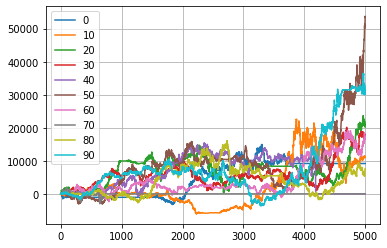

In [276]:
for i in range(0, epochs,epochs//10):
    plt.plot(profits[i])
plt.legend(list(range(0, epochs+50,epochs//10)))
plt.grid()
plt.show()

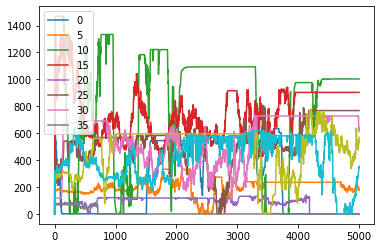

In [278]:
for i in range(0, epochs, epochs//10):
    plt.plot(shares[i, :, 0])

plt.legend(list(range(0, 40, 5)))
plt.show()

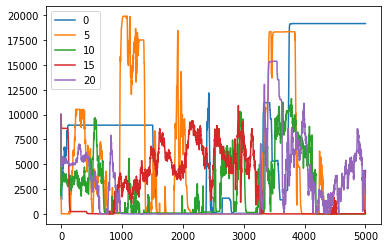

In [279]:
for i in range(0, epochs, epochs//5):
    plt.plot(balances[i])

plt.legend(list(range(0, 40, 5)))
plt.show()

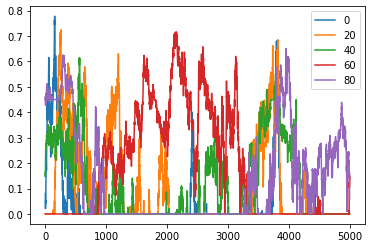

In [280]:
for i in range(0,  epochs, epochs//5):
    plt.plot(actions[i, :, 0])
   # plt.plot(-actions[i, :, 1])
plt.legend(list(range(0, 100, 20)))
plt.show()

In [281]:
print(env.net_worth)
print(env.balance)
print(env.shares_held)

38991.5806428426
13256.07244021116
[[24.]]


In [285]:
files = [np.random.choice(stocks)]
print(files)
def test(values):
    num = len(values)
    env = create_stock_env(files, train = False)
    agent = Agent(AGENT_PARAMS, train = False, resume = True)
    print(agent.num_steps)
    max_steps = env.max_steps
    profitst = np.zeros((num, max_steps))
    balancest = np.zeros((num, max_steps + 1))
    sharest = np.zeros((num, max_steps+1, agent.action_dimensions))
    actionst = np.zeros((num, max_steps+1, agent.action_dimensions*2))

    for count, val in enumerate(values):
        profit = 0
        observation, info = env.reset(intial_balance = val)
        balancest[count][0] = info['balance']
#         print(info['balance'])
        sharest[count][0] = info['shares_held']
#         print(info['shares_held'])
        agent.agent_start()
        action = agent.agent_step(0,observation)
        actionst[count][0] = action

        for i in tqdm(range(max_steps)):
            observation, reward, done, info = env.step(action)
            profit += reward
            profitst[count][i] = profit
            balancest[count][i+1] = info['balance']
            sharest[count][i+1] = info['shares_held']
            #print(action)
            #print('state',agent.state)
            if done:
                break
            action = agent.agent_step(reward, observation)
            actionst[count][i+1] = action
#             print('o',action)
        print(profitst[-1])
        print('Completed' + str(count) + 'values')

    return profitst, balancest, sharest, actionst


['PNB.csv']


In [286]:
values = [1000, 5000, 10000, 20000, 50000]
profitst, balancest, sharest, actionst = test(values)

loading
Successfully Loaded


  2%|▏         | 43/2572 [00:00<00:06, 419.83it/s]

435000
current_step 0


  2%|▏         | 43/2572 [00:00<00:06, 418.91it/s]

[0. 0. 0. ... 0. 0. 0.]
Completed0values
current_step 0


  2%|▏         | 42/2572 [00:00<00:06, 411.78it/s]

[0. 0. 0. ... 0. 0. 0.]
Completed1values
current_step 0


  2%|▏         | 42/2572 [00:00<00:06, 411.39it/s]

[0. 0. 0. ... 0. 0. 0.]
Completed2values
current_step 0


  2%|▏         | 42/2572 [00:00<00:06, 411.06it/s]

[0. 0. 0. ... 0. 0. 0.]
Completed3values
current_step 0


100%|█████████▉| 2571/2572 [00:06<00:00, 414.70it/s]

[     0.           -104.91953476   -134.07506099 ... -40303.71822606
 -39589.79495784 -39589.79495784]
Completed4values


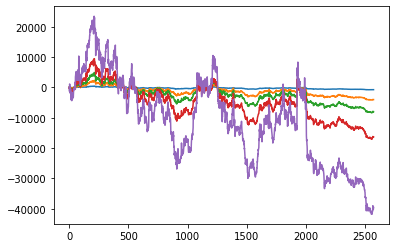

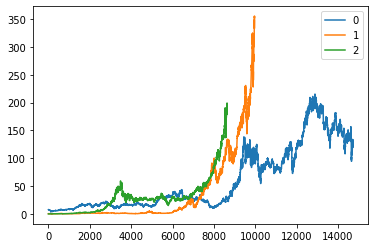

105.925003

In [287]:
for i in range(5):
    plt.plot(profitst[i,:])
plt.show()
df2 = pd.read_csv('MSFT.csv')
df = pd.read_csv('IBM.csv')
df1 = pd.read_csv('AAPL.csv')
plt.plot(df['Open'])
plt.plot(df1['Open'])
plt.plot(df2['Open'])
plt.legend(list(range(6)))
plt.show()
df3.loc[0,'Open']

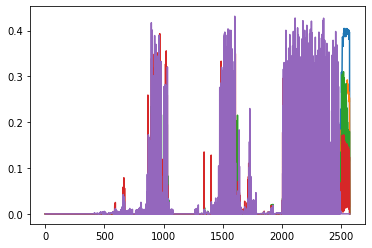

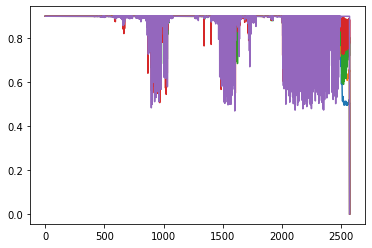

In [290]:
for i in range(5):
    plt.plot(actionst[i,:,0])
plt.show()
for i in range(5):
    plt.plot(actionst[i,:,1])
plt.show()
plt.show()

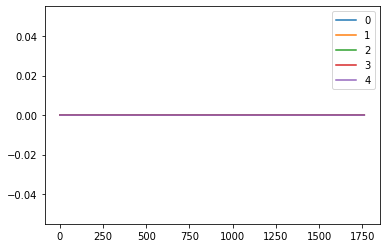

In [250]:
for i in range(5):
    plt.plot(sharest[i, :, 1])

plt.legend(list(range(5)))
plt.show()

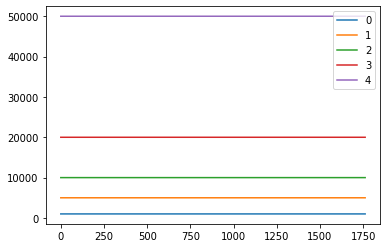

In [251]:
for i in range(5):
    plt.plot(balancest[i])
plt.legend(list(range(5)))
plt.show()

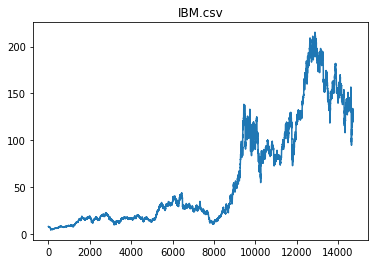

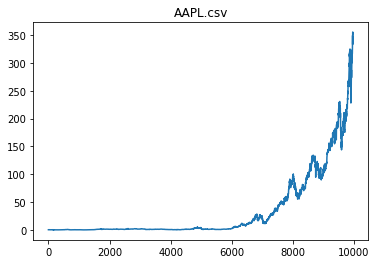

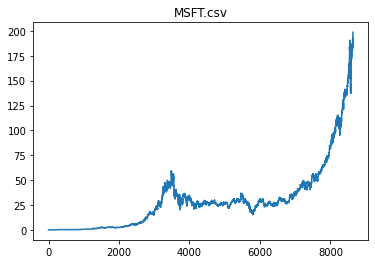

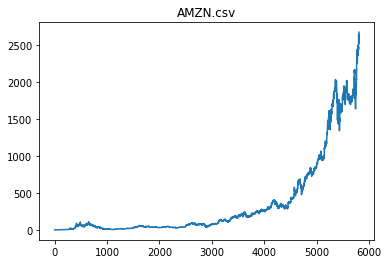

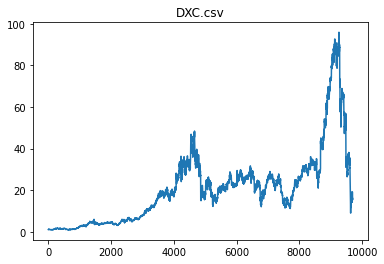

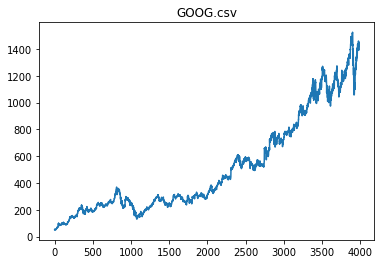

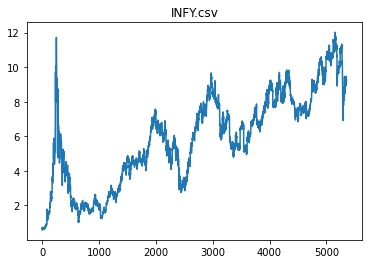

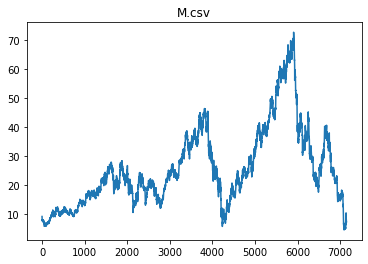

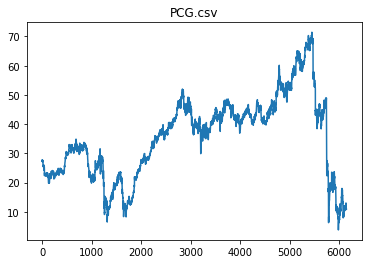

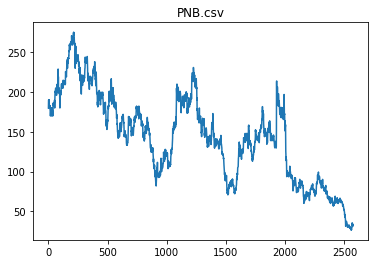

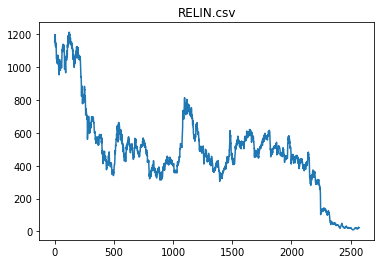

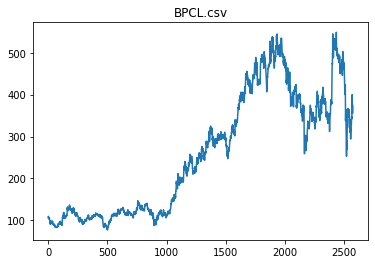

In [255]:
for i in stocks:
    df = pd.read_csv(i)
    plt.plot(df['Open'])
    plt.title(i)
    plt.show()

    
#dxc,m,pcg   
#IBM
#infy
#google,aapl,msft,amzn

In [ ]:

plt.plot(df.loc[:,'Close'])
plt.plot(df.loc[:,'Open'])
plt.plot(df.loc[:,'High'])
plt.plot(df.loc[:,'Low'])

In [ ]:
plt.plot(df1.loc[:,'Close'])
plt.plot(df1.loc[:,'Open'])
plt.plot(df1.loc[:,'High'])
plt.plot(df1.loc[:,'Low'])

In [ ]:
plt.plot(df2.loc[:,'Close'])
plt.plot(df2.loc[:,'Open'])
plt.plot(df2.loc[:,'High'])
plt.plot(df2.loc[:,'Low'])